# Learning a quadratic prior

This code attempts to learn a concave quadratic prior $J(x) = -\frac{1}{4}||x||_2^2$ in the context of a Hamilton-Jacobi PDE with a quadratic Hamiltonian $H(p) = \frac{1}{2}||p||_2^2$.
The LPN learns the function $\psi(x) = ||x||_2^2$.

## Import modules 

In [1]:
import os
import numpy as np
import torch

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import seaborn as sns

from network import LPN
from lib.utils import cvx
from lib.invert import invert

# set location
MODEL_DIR = "experiments/models/concave_quadratic_prior_64D"
os.makedirs(MODEL_DIR, exist_ok=True)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# set random seeds
np.random.seed(1)
torch.manual_seed(1)

# plotting options
plt.rcParams.update({"text.usetex": False})
sns.set_theme()

## Parameters

In [2]:
# Parameters
# --- Parameters fof Experiment ---
dim_exp = 64  # Dimension (e.g., 2D, 4D, 8D as in the paper)
data_points_exp = 40000 # Example number of data points
iterations_exp_initial = 1 # Iterations for initial training phase
iterations_exp_long = 500000 # Iterations for longer training phase
a_exp = 4 # Grid limit for sampling y_j if using uniform, e.g., y_j in [-a, a]^d
spacing = 50 # For plotting cross-sections


# LPN model parameters
# Note: The defaults parameters are beta = 10, hidden = 50, layers = 4
beta = 10       # beta of softplus
hidden = 50     # number of hidden units
layers = 4      # number of layers
eps = 0.5
# optimization algorithm to use for computing the prior (cvx_cg, cvx_gd)
INVERT_MODE = "cvx_gd"

# === Section ===

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import torch 

# === Section 4.1.2: L1 Prior Helper Functions ===

def inner_prod(x, y):
    return np.sum(x * y, axis=1)

def euclid_norm_sq(x):
    if x.ndim == 1:
        return np.sum(x*x)
    return np.sum(x * x, axis=1)


def cvx_true_concave_quad(y_points): # y_points is N x dim
    """
    Computes the target function psi(y) = ||y||_2^2 for the given problem.
    """
    return euclid_norm_sq(y_points)

def prior_true_concave_quad(x_points):
    """
    Computes the true concave prior J(x) = -1/4 * ||x||_2^2.
    """
    return -0.25 * euclid_norm_sq(x_points)

def invert_prior_lpn(x, model, INVERT_MODE):
    y = invert(x,model,INVERT_MODE)
    return y

def evaluate_learned_prior_lpn(x_eval_points, y_inverted_points, model):
    try:
        y_tensor = torch.from_numpy(y_inverted_points).float().to(device)
        psi_of_y_inverted = model.scalar(y_tensor).squeeze(1).detach().cpu().numpy()
    except NameError: 
        print("Warning: 'device' not defined. Assuming CPU for evaluate_learned_prior.")
        y_tensor = torch.from_numpy(y_inverted_points).float()
        psi_of_y_inverted = model.scalar(y_tensor).squeeze(1).detach().numpy()
    prior_est = inner_prod(x_eval_points, y_inverted_points) - 0.5 * euclid_norm_sq(x_eval_points) - psi_of_y_inverted
    return prior_est


def compute_square_cross_sections(a, spacing, dim):
    xi = np.linspace(-a, a, spacing)
    grid = np.zeros((xi.size, dim))
    x1_0_points = np.copy(grid)
    x1_0_points[:, 0] = xi
    x2_0_points = np.copy(grid)
    if dim > 1:
        x2_0_points[:, 1] = xi
    elif dim == 1:
        x2_0_points = x1_0_points.copy()
    return xi, x1_0_points, x2_0_points

def cross_sections_plots_concave_quad(model, a, spacing, INVERT_MODE, dim):
    xi, x1_0_points, x2_0_points = compute_square_cross_sections(a, spacing, dim)
    
    x1_0_psi_true = cvx_true_concave_quad(x1_0_points)
    x1_0_J_true = prior_true_concave_quad(x1_0_points)
    if dim > 1:
        x2_0_psi_true = cvx_true_concave_quad(x2_0_points)
        x2_0_J_true = prior_true_concave_quad(x2_0_points)
    else: 
        x2_0_psi_true = x1_0_psi_true 
        x2_0_J_true = x1_0_J_true
        
    x1_0_psi_est = cvx(x1_0_points, model) 
    y1_inverted = invert_prior_lpn(x1_0_points, model, INVERT_MODE)
    x1_0_J_est = evaluate_learned_prior_lpn(x1_0_points,y1_inverted, model)
    if dim > 1:
        x2_0_psi_est = cvx(x2_0_points, model)
        y2_inverted = invert_prior_lpn(x2_0_points, model, INVERT_MODE)
        x2_0_J_est = evaluate_learned_prior_lpn(x2_0_points,y2_inverted, model)
    else:
        x2_0_psi_est = x1_0_psi_est
        x2_0_J_est = x1_0_J_est
        
    plt.figure(figsize=(12,5))
    plt.subplot(1, 2, 1)
    plt.plot(xi, x1_0_psi_est, "-", ms=5, label="LPN (Learned $\\psi$)")
    plt.plot(xi, x1_0_psi_true, "--", ms=5, label="True $\\psi$ for $J(x)=\\|x\\|_1$")
    plt.grid(True)
    plt.title(f"$\\psi(y_1,0,...)$ - Dim {dim}, $J(x)=\\|x\\|_1$")
    plt.xlabel('$y_1$')
    plt.ylabel('$\\psi(y_1,0,...)$')
    plt.legend()

    if dim > 1:
        plt.subplot(1, 2, 2) # Second plot for psi if dim > 1
        plt.plot(xi, x2_0_psi_est, "-", ms=5, label="LPN (Learned $\\psi$)")
        plt.plot(xi, x2_0_psi_true, "--", ms=5, label="True $\\psi$ for $J(x)=-1/4\\|x\\|_2^2$")
        plt.grid(True)
        plt.title(f"$\\psi(0,y_2,0,...)$ - Dim {dim}, $J(x)=-1/4\\|x\\|_2^2$")
        plt.xlabel('$y_2$')
        plt.ylabel('$\\psi(0,y_2,0,...)$')
        plt.legend()
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(12,5))
    plt.subplot(1, 2, 1)
    plt.plot(xi, x1_0_J_est, "-", label="LPN (Learned $J$)")
    plt.plot(xi, x1_0_J_true, "--", label="True $J(x)=-1/4\\|x\\|_2^2$")
    plt.grid(True)
    plt.title(f"Prior $J(x_1,0,...)$ - Dim {dim}, $J(x)=-1/4\\|x\\|_2^2$")
    plt.xlabel('$x_1$')
    plt.ylabel('$J(x_1,0,...)$')
    plt.legend()

    if dim > 1:
        plt.subplot(1, 2, 2)
        plt.plot(xi, x2_0_J_est, "-", label="LPN (Learned $J$)")
        plt.plot(xi, x2_0_J_true, "--", label="True $J(x)=-1/4\\|x\\|_2^2$")
        plt.grid(True)
        plt.title(f"Prior $J(0,x_2,0,...)$ - Dim {dim}, $J(x)=-1/4\\|x\\|_2^2$")
        plt.xlabel('$x_2$')
        plt.ylabel('$J(0,x_2,0,...)$')
        plt.legend()
    plt.tight_layout()
    plt.show()

def plot_all_concave_quad(model, a, spacing, INVERT_MODE, dim):
    print(f"\n--- Plotting Cross Sections for Quadratic H, Quadratic concave Prior (Dim={dim}) ---")
    cross_sections_plots_concave_quad(model, a, spacing, INVERT_MODE, dim)



In [4]:
def evaluate_learned_H(model, a, spacing, dim):
    """
    Calculates and plots the approximate Hamiltonian H_theta.
    H_theta(p) = max_k { <p, eta_k> - b_k }
    where eta_k = x_k - grad_psi(x_k) and b_k = 0.5 * ||eta_k||^2
    """
    x_k_np = np.random.uniform(-a, a, (data_points_exp, dim))
    x_k_tensor = torch.from_numpy(x_k_np).float().to(device)
    x_k_tensor.requires_grad_(True)
    grad_psi_k_tensor = model(x_k_tensor)

    eta_k_tensor = x_k_tensor - grad_psi_k_tensor
    b_k_tensor = 0.5 * torch.sum(eta_k_tensor**2, dim=1, keepdim=True)

    xi = np.linspace(-a, a, spacing)
    p_eval_points_np = np.zeros((xi.size, dim))
    p_eval_points_np[:, 0] = xi
    p_eval_tensor = torch.from_numpy(p_eval_points_np).float().to(device)

    # Compute H_theta(p) for the cross-section
    inner_prods = torch.matmul(p_eval_tensor, eta_k_tensor.T)  # (spacing x data_points)
    H_theta_p_tensor = torch.max(inner_prods - b_k_tensor.T, dim=1, keepdim=True)[0]
    H_theta_p_np = H_theta_p_tensor.detach().cpu().numpy().flatten()

    # Compute true Hamiltonian H(p) = 0.5 * ||p||^2
    H_true_p_np = 0.5 * euclid_norm_sq(p_eval_points_np)

    plt.figure(figsize=(6,5))
    plt.plot(xi, H_theta_p_np, "-", label="Learned Hamiltonian $H_{\\theta}(p_1,0,...)$")
    plt.plot(xi, H_true_p_np, "--", label="True Hamiltonian $H(p)=1/2||p||_2^2$")
    plt.grid(True)
    plt.title(f"Hamiltonian Comparison - Dim {dim}")
    plt.xlabel('$p_1$')
    plt.ylabel('H(p)')
    plt.legend()
    plt.tight_layout()
    plt.show()


# --- Generate Training Data

In [5]:
# --- Generate Training Data for the new experiment ---
print("--- Generating Training Data for Concave Quadratic Prior ---")
y_j_exp_np = np.random.uniform(-a_exp, a_exp, (data_points_exp, dim_exp))
psi_samples_exp_np = cvx_true_concave_quad(y_j_exp_np)
psi_samples_exp_np = psi_samples_exp_np.reshape(-1, 1)

y_j_exp_tensor = torch.from_numpy(y_j_exp_np).float().to(device)
psi_samples_exp_tensor = torch.from_numpy(psi_samples_exp_np).float().to(device)
print(f"Generated training data: y_j_exp_tensor shape {y_j_exp_tensor.shape}, psi_samples_exp_tensor shape {psi_samples_exp_tensor.shape}")

# --- ADD THIS TO MOVE DATA TO GPU ---
y_j_exp_tensor = y_j_exp_tensor.to(device)
psi_samples_exp_tensor = psi_samples_exp_tensor.to(device)

--- Generating Training Data for Concave Quadratic Prior ---


Generated training data: y_j_exp_tensor shape torch.Size([20000, 64]), psi_samples_exp_tensor shape torch.Size([20000, 1])


## Training function

In [6]:
def single_iteration(i, data_points, lpn_model, optimizer,input,cvx_samples,loss_type, gamma_loss=None):
    # Compute the convex function from the input.
    cvx_out = lpn_model.scalar(input)

    # Calculate the loss function
    if loss_type == 2:
        loss = (cvx_out - cvx_samples).pow(2).sum() / data_points # MSE loss
    elif loss_type == 1:
        loss = (cvx_out - cvx_samples).abs().sum() / data_points    # MAE loss
    #elif loss_type == 0:
    #    loss = exp_func(cvx_out - cvx_samples, gamma_loss).mean()   # proximal matching loss
    else:
        raise ValueError("loss_type must be 0, 1, or 2")


    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    lpn_model.wclip()

    # monitor
    # loss_lstar = exp_func(out - target, 0.1).mean()

    if not i % 500:
        print("iteration", i, "loss", loss.item()) #, "loss_lstar", loss_lstar.item())

# Train

L2 loss -- Train

In [7]:

# --- Train and Plot with L2 Loss for the new experiment ---
print("\n--- Training LPN for Concave Quadratic Prior (Quadratic H) ---")
lpn_model_concave_quad_l2 = LPN(in_dim=dim_exp, hidden=hidden, layers=layers, beta=beta,eps=1e-3).to(device)
optimizer_concave_quad = torch.optim.Adam(lpn_model_concave_quad_l2.parameters(), lr=1e-4)

# Initial shorter training phase with a higher learning rate
for i in range(1):
     single_iteration(i, data_points_exp, lpn_model_concave_quad_l2, optimizer_concave_quad, y_j_exp_tensor, psi_samples_exp_tensor, loss_type=2, gamma_loss=None)

# Longer training phase with a reduced learning rate
for g in optimizer_concave_quad.param_groups:
    g["lr"] = 1e-4
for i in range(iterations_exp_long):
    if (i % 20000 == 0) and (i > 0): 
        # Multiply the current learning rate by 1e-1
        for g in optimizer_concave_quad.param_groups:
            new_lr = g["lr"] * 1e-1
            g["lr"] = new_lr
        print(f"Learning rate decreased to {new_lr} at iteration {i}")    
    single_iteration(i, data_points_exp, lpn_model_concave_quad_l2, optimizer_concave_quad, y_j_exp_tensor, psi_samples_exp_tensor, loss_type=2, gamma_loss=None)

torch.save(lpn_model_concave_quad_l2.state_dict(), os.path.join(MODEL_DIR, "ConcaveQuadraticH_l2.pth"))



--- Training LPN for Concave Quadratic Prior (Quadratic H) ---


iteration 0 loss 117847.0078125
iteration 0 loss 109872.25


iteration 500 loss 1271.871337890625


iteration 1000 loss 987.3411865234375


iteration 1500 loss 780.5185546875


iteration 2000 loss 635.0242919921875


iteration 2500 loss 531.7939453125


iteration 3000 loss 457.79498291015625


iteration 3500 loss 404.33160400390625


iteration 4000 loss 363.6566467285156


iteration 4500 loss 331.44744873046875


iteration 5000 loss 305.3328857421875


iteration 5500 loss 282.9674377441406


iteration 6000 loss 263.16290283203125


iteration 6500 loss 244.96524047851562


iteration 7000 loss 227.25599670410156


iteration 7500 loss 209.83792114257812


iteration 8000 loss 191.8067626953125


iteration 8500 loss 173.77792358398438


iteration 9000 loss 154.2427215576172


iteration 9500 loss 132.00099182128906


iteration 10000 loss 104.07270050048828


iteration 10500 loss 69.67540740966797


iteration 11000 loss 42.799400329589844


iteration 11500 loss 29.83807373046875


iteration 12000 loss 23.77286148071289


iteration 12500 loss 20.333389282226562


iteration 13000 loss 18.082229614257812


iteration 13500 loss 16.513832092285156


iteration 14000 loss 15.27565860748291


iteration 14500 loss 14.370458602905273


iteration 15000 loss 13.692376136779785


iteration 15500 loss 13.126160621643066


iteration 16000 loss 12.6957426071167


iteration 16500 loss 12.177898406982422


iteration 17000 loss 11.81616497039795


iteration 17500 loss 11.487935066223145


iteration 18000 loss 11.233304023742676


iteration 18500 loss 10.978161811828613


iteration 19000 loss 10.773425102233887


iteration 19500 loss 10.572893142700195


iteration 20000 loss 10.389129638671875


iteration 20500 loss 10.233346939086914


iteration 21000 loss 10.079314231872559


iteration 21500 loss 9.95328140258789


iteration 22000 loss 9.810809135437012


iteration 22500 loss 9.69515609741211


iteration 23000 loss 9.573641777038574


iteration 23500 loss 9.468093872070312


iteration 24000 loss 9.358932495117188


iteration 24500 loss 9.26997184753418


iteration 25000 loss 9.163243293762207


iteration 25500 loss 9.087818145751953


iteration 26000 loss 8.999724388122559


iteration 26500 loss 8.911881446838379


iteration 27000 loss 8.833176612854004


iteration 27500 loss 8.743300437927246


iteration 28000 loss 8.6688814163208


iteration 28500 loss 8.583354949951172


iteration 29000 loss 8.519497871398926


iteration 29500 loss 8.442874908447266


iteration 30000 loss 8.38662052154541


iteration 30500 loss 8.328438758850098


iteration 31000 loss 8.264413833618164


iteration 31500 loss 8.210765838623047


iteration 32000 loss 8.153922080993652


iteration 32500 loss 8.108003616333008


iteration 33000 loss 8.055495262145996


iteration 33500 loss 8.011981010437012


iteration 34000 loss 7.962303161621094


iteration 34500 loss 7.92621374130249


iteration 35000 loss 7.885687351226807


iteration 35500 loss 7.844005107879639


iteration 36000 loss 7.812167167663574


iteration 36500 loss 7.773401260375977


iteration 37000 loss 7.738855838775635


iteration 37500 loss 7.707405090332031


iteration 38000 loss 7.677750587463379


iteration 38500 loss 7.6418890953063965


iteration 39000 loss 7.609768390655518


iteration 39500 loss 7.577876567840576


iteration 40000 loss 7.551334381103516


iteration 40500 loss 7.671714782714844


iteration 41000 loss 7.493827819824219


iteration 41500 loss 7.466536521911621


iteration 42000 loss 7.437934398651123


iteration 42500 loss 7.415848255157471


iteration 43000 loss 7.389718532562256


iteration 43500 loss 7.366567611694336


iteration 44000 loss 7.3472442626953125


iteration 44500 loss 7.319005966186523


iteration 45000 loss 7.300810813903809


iteration 45500 loss 7.279565334320068


iteration 46000 loss 7.256763935089111


iteration 46500 loss 7.238894939422607


iteration 47000 loss 7.2298583984375


iteration 47500 loss 7.198204517364502


iteration 48000 loss 7.181327819824219


iteration 48500 loss 7.158110618591309


iteration 49000 loss 7.142253875732422


iteration 49500 loss 7.122342586517334


iteration 50000 loss 7.105203151702881


iteration 50500 loss 7.089206695556641


iteration 51000 loss 7.068223476409912


iteration 51500 loss 7.0537238121032715


iteration 52000 loss 7.0376410484313965


iteration 52500 loss 7.0181121826171875


iteration 53000 loss 7.004498481750488


iteration 53500 loss 6.988176345825195


iteration 54000 loss 6.9713826179504395


iteration 54500 loss 6.956704616546631


iteration 55000 loss 6.9426093101501465


iteration 55500 loss 6.926814556121826


iteration 56000 loss 6.912948131561279


iteration 56500 loss 6.896763324737549


iteration 57000 loss 6.885398864746094


iteration 57500 loss 6.872859001159668


iteration 58000 loss 6.862236499786377


iteration 58500 loss 6.8458781242370605


iteration 59000 loss 6.832783222198486


iteration 59500 loss 6.818962097167969


iteration 60000 loss 6.808284282684326


iteration 60500 loss 6.795167922973633


iteration 61000 loss 6.7835187911987305


iteration 61500 loss 6.773584842681885


iteration 62000 loss 6.761159420013428


iteration 62500 loss 6.749257564544678


iteration 63000 loss 6.739365577697754


iteration 63500 loss 6.726327896118164


iteration 64000 loss 6.715741157531738


iteration 64500 loss 6.704646587371826


iteration 65000 loss 6.692710876464844


iteration 65500 loss 6.684424877166748


iteration 66000 loss 6.674195766448975


iteration 66500 loss 6.662777900695801


iteration 67000 loss 6.6540093421936035


iteration 67500 loss 6.642943382263184


iteration 68000 loss 6.634303092956543


iteration 68500 loss 6.626281261444092


iteration 69000 loss 6.616703033447266


iteration 69500 loss 6.606990337371826


iteration 70000 loss 6.599359035491943


iteration 70500 loss 6.588460922241211


iteration 71000 loss 6.580419540405273


iteration 71500 loss 6.572455883026123


iteration 72000 loss 6.561882019042969


iteration 72500 loss 6.555120944976807


iteration 73000 loss 6.547231674194336


iteration 73500 loss 6.539082050323486


iteration 74000 loss 6.53065824508667


iteration 74500 loss 6.523998737335205


iteration 75000 loss 6.516190528869629


iteration 75500 loss 6.506751537322998


iteration 76000 loss 6.498575687408447


iteration 76500 loss 6.489851951599121


iteration 77000 loss 6.483046531677246


iteration 77500 loss 6.475283145904541


iteration 78000 loss 6.467092990875244


iteration 78500 loss 6.459885120391846


iteration 79000 loss 6.602169513702393


iteration 79500 loss 6.445016860961914


iteration 80000 loss 6.438255310058594


iteration 80500 loss 6.4507951736450195


iteration 81000 loss 6.421861171722412


iteration 81500 loss 6.411859512329102


iteration 82000 loss 6.39838981628418


iteration 82500 loss 6.387644290924072


iteration 83000 loss 6.376340389251709


iteration 83500 loss 6.3596320152282715


iteration 84000 loss 6.346583366394043


iteration 84500 loss 6.332860469818115


iteration 85000 loss 6.319655418395996


iteration 85500 loss 6.308645248413086


iteration 86000 loss 6.294834136962891


iteration 86500 loss 6.2846550941467285


iteration 87000 loss 6.275595664978027


iteration 87500 loss 6.264765739440918


iteration 88000 loss 6.252882480621338


iteration 88500 loss 6.242152690887451


iteration 89000 loss 6.2302117347717285


iteration 89500 loss 6.220085620880127


iteration 90000 loss 6.210383415222168


iteration 90500 loss 6.1997389793396


iteration 91000 loss 6.192618370056152


iteration 91500 loss 6.18358850479126


iteration 92000 loss 6.172756195068359


iteration 92500 loss 6.165140628814697


iteration 93000 loss 6.156191349029541


iteration 93500 loss 6.145125389099121


iteration 94000 loss 6.137939929962158


iteration 94500 loss 6.129491806030273


iteration 95000 loss 6.120456218719482


iteration 95500 loss 6.1136956214904785


iteration 96000 loss 6.105456829071045


iteration 96500 loss 6.097468376159668


iteration 97000 loss 6.091142177581787


iteration 97500 loss 6.0823445320129395


iteration 98000 loss 6.075392723083496


iteration 98500 loss 6.069129467010498


iteration 99000 loss 6.0602707862854


iteration 99500 loss 6.054927825927734


iteration 100000 loss 6.048598766326904


iteration 100500 loss 6.040767669677734


iteration 101000 loss 6.035035133361816


iteration 101500 loss 6.028794288635254


iteration 102000 loss 6.021010398864746


iteration 102500 loss 6.015719413757324


iteration 103000 loss 6.009219169616699


iteration 103500 loss 6.00268030166626


iteration 104000 loss 5.997716426849365


iteration 104500 loss 5.992743015289307


iteration 105000 loss 5.98532247543335


iteration 105500 loss 5.980881690979004


iteration 106000 loss 5.974380016326904


iteration 106500 loss 5.968774795532227


iteration 107000 loss 5.963905334472656


iteration 107500 loss 5.958247661590576


iteration 108000 loss 5.953054904937744


iteration 108500 loss 5.948207378387451


iteration 109000 loss 5.942148685455322


iteration 109500 loss 5.937930107116699


iteration 110000 loss 5.934163570404053


iteration 110500 loss 6.1119842529296875


iteration 111000 loss 5.922924995422363


iteration 111500 loss 5.918176651000977


iteration 112000 loss 5.912606716156006


iteration 112500 loss 5.908807754516602


iteration 113000 loss 5.904043674468994


iteration 113500 loss 5.8988871574401855


iteration 114000 loss 5.8951921463012695


iteration 114500 loss 5.8908185958862305


iteration 115000 loss 5.8857951164245605


iteration 115500 loss 5.882175445556641


iteration 116000 loss 5.8776445388793945


iteration 116500 loss 5.873338222503662


iteration 117000 loss 5.869950771331787


iteration 117500 loss 5.8666887283325195


iteration 118000 loss 5.8613600730896


iteration 118500 loss 5.858015537261963


iteration 119000 loss 5.857366561889648


iteration 119500 loss 5.8499531745910645


iteration 120000 loss 5.846852779388428


iteration 120500 loss 5.843740463256836


iteration 121000 loss 5.838958740234375


iteration 121500 loss 5.836093425750732


iteration 122000 loss 5.833441734313965


iteration 122500 loss 5.828455924987793


iteration 123000 loss 5.825675010681152


iteration 123500 loss 5.822465419769287


iteration 124000 loss 5.818141460418701


iteration 124500 loss 5.815281867980957


iteration 125000 loss 5.812082767486572


iteration 125500 loss 5.807971000671387


iteration 126000 loss 5.805232048034668


iteration 126500 loss 5.8020195960998535


iteration 127000 loss 5.798220634460449


iteration 127500 loss 5.795614242553711


iteration 128000 loss 5.792862415313721


iteration 128500 loss 5.788649559020996


iteration 129000 loss 5.78605318069458


iteration 129500 loss 5.782979488372803


iteration 130000 loss 5.779162406921387


iteration 130500 loss 5.776779651641846


iteration 131000 loss 5.77402400970459


iteration 131500 loss 5.77719259262085


iteration 132000 loss 5.767291069030762


iteration 132500 loss 5.764866828918457


iteration 133000 loss 5.760426998138428


iteration 133500 loss 5.758013725280762


iteration 134000 loss 5.755063056945801


iteration 134500 loss 5.758504390716553


iteration 135000 loss 5.748997688293457


iteration 135500 loss 5.7461256980896


iteration 136000 loss 5.7435078620910645


iteration 136500 loss 5.740151882171631


iteration 137000 loss 5.737506866455078


iteration 137500 loss 5.734433174133301


iteration 138000 loss 5.731478691101074


iteration 138500 loss 5.731867790222168


iteration 139000 loss 5.725759029388428


iteration 139500 loss 5.722947597503662


iteration 140000 loss 5.7204270362854


iteration 140500 loss 5.717868804931641


iteration 141000 loss 5.71466064453125


iteration 141500 loss 5.712462902069092


iteration 142000 loss 5.709377765655518


iteration 142500 loss 5.706551551818848


iteration 143000 loss 5.704570293426514


iteration 143500 loss 5.701173305511475


iteration 144000 loss 5.698771953582764


iteration 144500 loss 5.696504592895508


iteration 145000 loss 5.694176197052002


iteration 145500 loss 5.691086769104004


iteration 146000 loss 5.6889824867248535


iteration 146500 loss 5.686380386352539


iteration 147000 loss 5.6834516525268555


iteration 147500 loss 5.68125057220459


iteration 148000 loss 5.680534839630127


iteration 148500 loss 5.675932884216309


iteration 149000 loss 5.67359733581543


iteration 149500 loss 5.670490264892578


iteration 150000 loss 5.668510913848877


iteration 150500 loss 5.666457176208496


iteration 151000 loss 5.663710117340088


iteration 151500 loss 5.660981178283691


iteration 152000 loss 5.658970355987549


iteration 152500 loss 5.656569480895996


iteration 153000 loss 5.653571128845215


iteration 153500 loss 5.6516571044921875


iteration 154000 loss 5.649433612823486


iteration 154500 loss 5.646791934967041


iteration 155000 loss 5.644459247589111


iteration 155500 loss 5.642443656921387


iteration 156000 loss 6.177417755126953


iteration 156500 loss 5.637131690979004


iteration 157000 loss 5.6348700523376465


iteration 157500 loss 5.633613109588623


iteration 158000 loss 5.6299920082092285


iteration 158500 loss 5.627895355224609


iteration 159000 loss 5.625389099121094


iteration 159500 loss 5.622831344604492


iteration 160000 loss 5.621059894561768


iteration 160500 loss 5.619167804718018


iteration 161000 loss 5.615702152252197


iteration 161500 loss 5.613652229309082


iteration 162000 loss 5.611231327056885


iteration 162500 loss 5.608613967895508


iteration 163000 loss 5.606716632843018


iteration 163500 loss 5.604987144470215


iteration 164000 loss 5.601582050323486


iteration 164500 loss 5.599742889404297


iteration 165000 loss 5.597909927368164


iteration 165500 loss 5.594850063323975


iteration 166000 loss 5.592677116394043


iteration 166500 loss 5.59062385559082


iteration 167000 loss 5.587772369384766


iteration 167500 loss 5.585845947265625


iteration 168000 loss 5.585383892059326


iteration 168500 loss 5.580960273742676


iteration 169000 loss 5.579156875610352


iteration 169500 loss 5.576927661895752


iteration 170000 loss 5.574316024780273


iteration 170500 loss 5.572415351867676


iteration 171000 loss 5.570120334625244


iteration 171500 loss 5.567596912384033


iteration 172000 loss 5.5658464431762695


iteration 172500 loss 5.566155910491943


iteration 173000 loss 5.567990779876709


iteration 173500 loss 5.559340476989746


iteration 174000 loss 5.557450771331787


iteration 174500 loss 5.555459976196289


iteration 175000 loss 5.552736759185791


iteration 175500 loss 5.550713062286377


iteration 176000 loss 5.549067974090576


iteration 176500 loss 5.546220302581787


iteration 177000 loss 5.545228958129883


iteration 177500 loss 5.542362213134766


iteration 178000 loss 5.539729595184326


iteration 178500 loss 5.537751197814941


iteration 179000 loss 5.536710739135742


iteration 179500 loss 5.533364772796631


iteration 180000 loss 5.531440734863281


iteration 180500 loss 5.531554698944092


iteration 181000 loss 5.527124404907227


iteration 181500 loss 5.525122165679932


iteration 182000 loss 5.997607707977295


iteration 182500 loss 5.52110481262207


iteration 183000 loss 5.519339084625244


iteration 183500 loss 5.518887042999268


iteration 184000 loss 5.515106201171875


iteration 184500 loss 5.513293743133545


iteration 185000 loss 5.511053562164307


iteration 185500 loss 5.5092387199401855


iteration 186000 loss 5.507570266723633


iteration 186500 loss 5.50642204284668


iteration 187000 loss 5.50351619720459


iteration 187500 loss 5.501727104187012


iteration 188000 loss 5.499808311462402


iteration 188500 loss 5.498005390167236


iteration 189000 loss 5.496455192565918


iteration 189500 loss 5.4951348304748535


iteration 190000 loss 5.4925923347473145


iteration 190500 loss 5.490988254547119


iteration 191000 loss 5.489172458648682


iteration 191500 loss 5.487381458282471


iteration 192000 loss 5.485899925231934


iteration 192500 loss 5.484178066253662


iteration 193000 loss 5.4822492599487305


iteration 193500 loss 5.480872631072998


iteration 194000 loss 5.479918479919434


iteration 194500 loss 5.4771809577941895


iteration 195000 loss 5.475841045379639


iteration 195500 loss 5.474308490753174


iteration 196000 loss 5.472287178039551


iteration 196500 loss 5.470941066741943


iteration 197000 loss 5.469424724578857


iteration 197500 loss 5.467369556427002


iteration 198000 loss 5.466063976287842


iteration 198500 loss 5.464489936828613


iteration 199000 loss 5.462586879730225


iteration 199500 loss 5.461386680603027


iteration 200000 loss 5.459894180297852


iteration 200500 loss 5.458455562591553


iteration 201000 loss 5.456678867340088


iteration 201500 loss 5.456719875335693


iteration 202000 loss 5.453942775726318


iteration 202500 loss 5.452066421508789


iteration 203000 loss 5.4509100914001465


iteration 203500 loss 5.449136734008789


iteration 204000 loss 5.4475016593933105


iteration 204500 loss 5.447273254394531


iteration 205000 loss 5.444429397583008


iteration 205500 loss 5.443115711212158


iteration 206000 loss 5.441858291625977


iteration 206500 loss 5.442863941192627


iteration 207000 loss 5.438806056976318


iteration 207500 loss 5.437551021575928


iteration 208000 loss 5.435986518859863


iteration 208500 loss 5.434524059295654


iteration 209000 loss 5.433440208435059


iteration 209500 loss 5.432089805603027


iteration 210000 loss 5.431232452392578


iteration 210500 loss 5.4292168617248535


iteration 211000 loss 5.428309440612793


iteration 211500 loss 5.428922653198242


iteration 212000 loss 5.425182819366455


iteration 212500 loss 5.424042701721191


iteration 213000 loss 5.422734260559082


iteration 213500 loss 5.421175479888916


iteration 214000 loss 5.420071601867676


iteration 214500 loss 5.418701171875


iteration 215000 loss 5.417195796966553


iteration 215500 loss 5.416114330291748


iteration 216000 loss 5.414779186248779


iteration 216500 loss 5.413260459899902


iteration 217000 loss 5.4121832847595215


iteration 217500 loss 5.411830425262451


iteration 218000 loss 5.409434795379639


iteration 218500 loss 5.408466339111328


iteration 219000 loss 5.407261371612549


iteration 219500 loss 5.405725002288818


iteration 220000 loss 5.404767990112305


iteration 220500 loss 5.403843879699707


iteration 221000 loss 5.4025983810424805


iteration 221500 loss 5.401125431060791


iteration 222000 loss 5.400082111358643


iteration 222500 loss 5.3990044593811035


iteration 223000 loss 5.397502899169922


iteration 223500 loss 5.396552562713623


iteration 224000 loss 5.395730972290039


iteration 224500 loss 5.394170761108398


iteration 225000 loss 5.392938137054443


iteration 225500 loss 5.39172887802124


iteration 226000 loss 5.390366077423096


iteration 226500 loss 5.389479637145996


iteration 227000 loss 5.388378620147705


iteration 227500 loss 5.38796329498291


iteration 228000 loss 5.386025428771973


iteration 228500 loss 5.3850812911987305


iteration 229000 loss 5.384189128875732


iteration 229500 loss 5.382616996765137


iteration 230000 loss 5.381739616394043


iteration 230500 loss 5.380651473999023


iteration 231000 loss 5.428691387176514


iteration 231500 loss 5.378352165222168


iteration 232000 loss 5.377496719360352


iteration 232500 loss 5.377374649047852


iteration 233000 loss 5.375123023986816


iteration 233500 loss 5.37443208694458


iteration 234000 loss 5.37293815612793


iteration 234500 loss 5.371831893920898


iteration 235000 loss 5.370856285095215


iteration 235500 loss 5.369699954986572


iteration 236000 loss 5.368650436401367


iteration 236500 loss 5.367765426635742


iteration 237000 loss 5.366783618927002


iteration 237500 loss 5.3654632568359375


iteration 238000 loss 5.364652633666992


iteration 238500 loss 5.3643999099731445


iteration 239000 loss 5.365081787109375


iteration 239500 loss 5.3614983558654785


iteration 240000 loss 5.3605546951293945


iteration 240500 loss 5.359609127044678


iteration 241000 loss 5.358395099639893


iteration 241500 loss 5.3575944900512695


iteration 242000 loss 5.356752872467041


iteration 242500 loss 5.355405330657959


iteration 243000 loss 5.354499816894531


iteration 243500 loss 5.353355407714844


iteration 244000 loss 5.35242223739624


iteration 244500 loss 5.351595878601074


iteration 245000 loss 5.350570201873779


iteration 245500 loss 5.349433422088623


iteration 246000 loss 5.348596572875977


iteration 246500 loss 5.348001956939697


iteration 247000 loss 5.346453666687012


iteration 247500 loss 5.345603942871094


iteration 248000 loss 5.344780445098877


iteration 248500 loss 5.343538761138916


iteration 249000 loss 5.3428053855896


iteration 249500 loss 5.341969966888428


iteration 250000 loss 5.3409342765808105


iteration 250500 loss 5.339968681335449


iteration 251000 loss 5.339457988739014


iteration 251500 loss 5.338767051696777


iteration 252000 loss 5.3371806144714355


iteration 252500 loss 5.336350440979004


iteration 253000 loss 5.335417747497559


iteration 253500 loss 5.334406852722168


iteration 254000 loss 5.333706855773926


iteration 254500 loss 5.333113193511963


iteration 255000 loss 5.332049369812012


iteration 255500 loss 5.330938816070557


iteration 256000 loss 5.330063343048096


iteration 256500 loss 5.329685688018799


iteration 257000 loss 5.328226566314697


iteration 257500 loss 5.327616214752197


iteration 258000 loss 5.327049255371094


iteration 258500 loss 5.325560569763184


iteration 259000 loss 5.324831962585449


iteration 259500 loss 5.324049949645996


iteration 260000 loss 5.322902202606201


iteration 260500 loss 5.322229862213135


iteration 261000 loss 5.321451663970947


iteration 261500 loss 5.320333480834961


iteration 262000 loss 5.3196187019348145


iteration 262500 loss 5.318873882293701


iteration 263000 loss 5.318002223968506


iteration 263500 loss 5.317025661468506


iteration 264000 loss 5.316307067871094


iteration 264500 loss 5.31543493270874


iteration 265000 loss 5.314452171325684


iteration 265500 loss 5.313798904418945


iteration 266000 loss 5.313140392303467


iteration 266500 loss 5.312451362609863


iteration 267000 loss 5.311252117156982


iteration 267500 loss 5.310662746429443


iteration 268000 loss 5.309536933898926


iteration 268500 loss 5.308692932128906


iteration 269000 loss 5.307993412017822


iteration 269500 loss 5.307365417480469


iteration 270000 loss 5.306141376495361


iteration 270500 loss 5.305428981781006


iteration 271000 loss 5.3062944412231445


iteration 271500 loss 5.303595542907715


iteration 272000 loss 5.3029465675354


iteration 272500 loss 5.302855014801025


iteration 273000 loss 5.3017425537109375


iteration 273500 loss 5.300426483154297


iteration 274000 loss 5.300414085388184


iteration 274500 loss 5.299748420715332


iteration 275000 loss 5.297945976257324


iteration 275500 loss 5.29722785949707


iteration 276000 loss 5.296221733093262


iteration 276500 loss 5.295475006103516


iteration 277000 loss 5.294726371765137


iteration 277500 loss 5.294220924377441


iteration 278000 loss 5.29301643371582


iteration 278500 loss 5.29227352142334


iteration 279000 loss 5.291359901428223


iteration 279500 loss 5.290609359741211


iteration 280000 loss 5.289921760559082


iteration 280500 loss 5.2893147468566895


iteration 281000 loss 5.288201808929443


iteration 281500 loss 5.287562370300293


iteration 282000 loss 5.286929607391357


iteration 282500 loss 5.286066055297852


iteration 283000 loss 5.285228252410889


iteration 283500 loss 5.284663677215576


iteration 284000 loss 5.2859086990356445


iteration 284500 loss 5.28285026550293


iteration 285000 loss 5.282142639160156


iteration 285500 loss 5.281259059906006


iteration 286000 loss 5.2805047035217285


iteration 286500 loss 5.279829502105713


iteration 287000 loss 5.279146671295166


iteration 287500 loss 5.278162479400635


iteration 288000 loss 5.277463912963867


iteration 288500 loss 5.276623249053955


iteration 289000 loss 5.275858402252197


iteration 289500 loss 5.275239944458008


iteration 290000 loss 5.274725437164307


iteration 290500 loss 5.273698329925537


iteration 291000 loss 5.272882461547852


iteration 291500 loss 5.272143840789795


iteration 292000 loss 5.271287441253662


iteration 292500 loss 5.270534038543701


iteration 293000 loss 5.2698283195495605


iteration 293500 loss 5.269261360168457


iteration 294000 loss 5.268235206604004


iteration 294500 loss 5.267634868621826


iteration 295000 loss 5.266903400421143


iteration 295500 loss 5.300719261169434


iteration 296000 loss 5.26539421081543


iteration 296500 loss 5.26472806930542


iteration 297000 loss 5.264976978302002


iteration 297500 loss 5.263131141662598


iteration 298000 loss 5.262503623962402


iteration 298500 loss 5.262077808380127


iteration 299000 loss 5.260857582092285


iteration 299500 loss 5.260258674621582


iteration 300000 loss 5.259528636932373


iteration 300500 loss 5.259088516235352


iteration 301000 loss 5.2580389976501465


iteration 301500 loss 5.257641315460205


iteration 302000 loss 5.257224082946777


iteration 302500 loss 5.255832195281982


iteration 303000 loss 5.255201816558838


iteration 303500 loss 6.730693817138672


iteration 304000 loss 5.253640651702881


iteration 304500 loss 5.253020286560059


iteration 305000 loss 5.276004791259766


iteration 305500 loss 5.2514801025390625


iteration 306000 loss 5.251542091369629


iteration 306500 loss 5.250680446624756


iteration 307000 loss 5.249373912811279


iteration 307500 loss 5.24889612197876


iteration 308000 loss 5.2481255531311035


iteration 308500 loss 5.247291088104248


iteration 309000 loss 5.246714115142822


iteration 309500 loss 5.246547698974609


iteration 310000 loss 5.245211124420166


iteration 310500 loss 5.244674205780029


iteration 311000 loss 5.244148254394531


iteration 311500 loss 5.24371337890625


iteration 312000 loss 5.24263334274292


iteration 312500 loss 5.242048263549805


iteration 313000 loss 5.241744518280029


iteration 313500 loss 5.240578651428223


iteration 314000 loss 5.240048408508301


iteration 314500 loss 5.239418983459473


iteration 315000 loss 5.578196048736572


iteration 315500 loss 5.238028049468994


iteration 316000 loss 5.2374372482299805


iteration 316500 loss 5.236647605895996


iteration 317000 loss 5.2360453605651855


iteration 317500 loss 5.235500812530518


iteration 318000 loss 5.234951496124268


iteration 318500 loss 5.234046459197998


iteration 319000 loss 5.2335333824157715


iteration 319500 loss 5.2328972816467285


iteration 320000 loss 5.274691104888916


iteration 320500 loss 5.231600284576416


iteration 321000 loss 5.231014728546143


iteration 321500 loss 5.230343341827393


iteration 322000 loss 5.229660511016846


iteration 322500 loss 5.229114055633545


iteration 323000 loss 5.228448867797852


iteration 323500 loss 5.227703094482422


iteration 324000 loss 5.2271623611450195


iteration 324500 loss 5.226834297180176


iteration 325000 loss 5.225776195526123


iteration 325500 loss 5.225286483764648


iteration 326000 loss 5.224783897399902


iteration 326500 loss 5.224119186401367


iteration 327000 loss 5.223385334014893


iteration 327500 loss 5.222817420959473


iteration 328000 loss 5.222164630889893


iteration 328500 loss 5.221434593200684


iteration 329000 loss 5.220893383026123


iteration 329500 loss 5.22171688079834


iteration 330000 loss 5.219532489776611


iteration 330500 loss 5.219024181365967


iteration 331000 loss 5.218477249145508


iteration 331500 loss 5.219020366668701


iteration 332000 loss 5.217183589935303


iteration 332500 loss 5.21665620803833


iteration 333000 loss 5.216134071350098


iteration 333500 loss 5.215315341949463


iteration 334000 loss 5.214835166931152


iteration 334500 loss 5.214234828948975


iteration 335000 loss 5.213587284088135


iteration 335500 loss 5.212983131408691


iteration 336000 loss 5.21243953704834


iteration 336500 loss 5.212535381317139


iteration 337000 loss 5.211157321929932


iteration 337500 loss 5.210664749145508


iteration 338000 loss 5.210063934326172


iteration 338500 loss 5.209414005279541


iteration 339000 loss 5.208827972412109


iteration 339500 loss 5.208291053771973


iteration 340000 loss 5.2077131271362305


iteration 340500 loss 5.20703649520874


iteration 341000 loss 5.206528186798096


iteration 341500 loss 5.205964088439941


iteration 342000 loss 5.205245018005371


iteration 342500 loss 5.20477294921875


iteration 343000 loss 5.2043375968933105


iteration 343500 loss 6.25784969329834


iteration 344000 loss 5.203017711639404


iteration 344500 loss 5.202497959136963


iteration 345000 loss 5.202094554901123


iteration 345500 loss 5.201236248016357


iteration 346000 loss 5.200718402862549


iteration 346500 loss 5.200087547302246


iteration 347000 loss 5.19945764541626


iteration 347500 loss 5.1989827156066895


iteration 348000 loss 5.1987833976745605


iteration 348500 loss 5.198272705078125


iteration 349000 loss 5.197203636169434


iteration 349500 loss 5.196619987487793


iteration 350000 loss 5.202450752258301


iteration 350500 loss 5.195468425750732


iteration 351000 loss 5.194977283477783


iteration 351500 loss 5.194413185119629


iteration 352000 loss 5.193700313568115


iteration 352500 loss 5.193260669708252


iteration 353000 loss 5.192733287811279


iteration 353500 loss 5.192070960998535


iteration 354000 loss 5.191493034362793


iteration 354500 loss 5.190943717956543


iteration 355000 loss 5.190578937530518


iteration 355500 loss 5.189725875854492


iteration 356000 loss 5.189212322235107


iteration 356500 loss 5.188592910766602


iteration 357000 loss 5.187969207763672


iteration 357500 loss 5.187448501586914


iteration 358000 loss 5.186872959136963


iteration 358500 loss 5.186209678649902


iteration 359000 loss 5.185701847076416


iteration 359500 loss 5.185087203979492


iteration 360000 loss 5.184464931488037


iteration 360500 loss 5.183967113494873


iteration 361000 loss 5.183502197265625


iteration 361500 loss 5.18271017074585


iteration 362000 loss 5.1822428703308105


iteration 362500 loss 5.182277202606201


iteration 363000 loss 5.184715747833252


iteration 363500 loss 5.180548667907715


iteration 364000 loss 5.18006706237793


iteration 364500 loss 5.179558277130127


iteration 365000 loss 5.1788506507873535


iteration 365500 loss 5.178390979766846


iteration 366000 loss 5.177812576293945


iteration 366500 loss 5.177301406860352


iteration 367000 loss 5.1766767501831055


iteration 367500 loss 5.1763153076171875


iteration 368000 loss 5.9386162757873535


iteration 368500 loss 5.174991607666016


iteration 369000 loss 5.174471855163574


iteration 369500 loss 5.174248695373535


iteration 370000 loss 5.173258304595947


iteration 370500 loss 5.172720909118652


iteration 371000 loss 5.172260284423828


iteration 371500 loss 5.1714606285095215


iteration 372000 loss 5.170943260192871


iteration 372500 loss 5.170358657836914


iteration 373000 loss 5.169733047485352


iteration 373500 loss 5.1692914962768555


iteration 374000 loss 5.168857574462891


iteration 374500 loss 5.168147563934326


iteration 375000 loss 5.167591571807861


iteration 375500 loss 5.167072296142578


iteration 376000 loss 5.166625499725342


iteration 376500 loss 5.165866374969482


iteration 377000 loss 5.165448188781738


iteration 377500 loss 5.164952754974365


iteration 378000 loss 5.1647844314575195


iteration 378500 loss 5.163763999938965


iteration 379000 loss 5.163356304168701


iteration 379500 loss 5.16270637512207


iteration 380000 loss 5.162115573883057


iteration 380500 loss 5.161676406860352


iteration 381000 loss 5.161231994628906


iteration 381500 loss 5.196993350982666


iteration 382000 loss 5.160062313079834


iteration 382500 loss 5.1595845222473145


iteration 383000 loss 5.159059524536133


iteration 383500 loss 5.158412933349609


iteration 384000 loss 5.157974720001221


iteration 384500 loss 5.1575541496276855


iteration 385000 loss 5.156859397888184


iteration 385500 loss 5.156403064727783


iteration 386000 loss 5.156030654907227


iteration 386500 loss 5.1554856300354


iteration 387000 loss 5.154824256896973


iteration 387500 loss 5.1543707847595215


iteration 388000 loss 5.153900623321533


iteration 388500 loss 5.153234481811523


iteration 389000 loss 5.152833461761475


iteration 389500 loss 5.152361869812012


iteration 390000 loss 5.151937961578369


iteration 390500 loss 5.151281356811523


iteration 391000 loss 5.150851726531982


iteration 391500 loss 5.150363445281982


iteration 392000 loss 5.1498589515686035


iteration 392500 loss 5.149321556091309


iteration 393000 loss 5.14885950088501


iteration 393500 loss 5.148362636566162


iteration 394000 loss 5.147764205932617


iteration 394500 loss 5.1473541259765625


iteration 395000 loss 5.146909236907959


iteration 395500 loss 5.184872627258301


iteration 396000 loss 5.145835876464844


iteration 396500 loss 5.145381927490234


iteration 397000 loss 5.145560264587402


iteration 397500 loss 5.144308567047119


iteration 398000 loss 5.143927097320557


iteration 398500 loss 5.143457889556885


iteration 399000 loss 5.143074035644531


iteration 399500 loss 5.142449378967285


iteration 400000 loss 5.142024040222168


iteration 400500 loss 5.14174747467041


iteration 401000 loss 5.140949249267578


iteration 401500 loss 5.140529632568359


iteration 402000 loss 5.140584945678711


iteration 402500 loss 5.139454364776611


iteration 403000 loss 5.13904333114624


iteration 403500 loss 5.138656139373779


iteration 404000 loss 5.137990474700928


iteration 404500 loss 5.137612819671631


iteration 405000 loss 5.137374401092529


iteration 405500 loss 5.1367411613464355


iteration 406000 loss 5.136161804199219


iteration 406500 loss 5.1357221603393555


iteration 407000 loss 5.135231971740723


iteration 407500 loss 5.134706974029541


iteration 408000 loss 5.134278297424316


iteration 408500 loss 5.134441375732422


iteration 409000 loss 5.133266925811768


iteration 409500 loss 5.132855415344238


iteration 410000 loss 5.132570743560791


iteration 410500 loss 5.131856918334961


iteration 411000 loss 5.1314921379089355


iteration 411500 loss 5.131049156188965


iteration 412000 loss 5.1309709548950195


iteration 412500 loss 5.1300764083862305


iteration 413000 loss 5.129627704620361


iteration 413500 loss 5.129101276397705


iteration 414000 loss 5.12869930267334


iteration 414500 loss 5.128316879272461


iteration 415000 loss 5.128513336181641


iteration 415500 loss 5.127292156219482


iteration 416000 loss 5.126904010772705


iteration 416500 loss 5.1267266273498535


iteration 417000 loss 5.12590217590332


iteration 417500 loss 5.125509262084961


iteration 418000 loss 5.124978542327881


iteration 418500 loss 5.130110263824463


iteration 419000 loss 5.1237406730651855


iteration 419500 loss 5.123112201690674


iteration 420000 loss 5.124286651611328


iteration 420500 loss 5.121568202972412


iteration 421000 loss 5.121007442474365


iteration 421500 loss 5.120456218719482


iteration 422000 loss 5.127386569976807


iteration 422500 loss 5.119126319885254


iteration 423000 loss 5.118562698364258


iteration 423500 loss 5.118122100830078


iteration 424000 loss 5.117267608642578


iteration 424500 loss 5.116605758666992


iteration 425000 loss 5.115785598754883


iteration 425500 loss 5.114455223083496


iteration 426000 loss 5.113333702087402


iteration 426500 loss 5.1116719245910645


iteration 427000 loss 5.1076812744140625


iteration 427500 loss 5.103825569152832


iteration 428000 loss 5.097058296203613


iteration 428500 loss 5.086958885192871


iteration 429000 loss 5.0769195556640625


iteration 429500 loss 5.0692667961120605


iteration 430000 loss 5.060405254364014


iteration 430500 loss 5.050909042358398


iteration 431000 loss 5.043097496032715


iteration 431500 loss 5.033332824707031


iteration 432000 loss 5.020369052886963


iteration 432500 loss 5.012749671936035


iteration 433000 loss 5.005822658538818


iteration 433500 loss 4.998525142669678


iteration 434000 loss 4.993006706237793


iteration 434500 loss 4.989110946655273


iteration 435000 loss 4.985439777374268


iteration 435500 loss 4.981705188751221


iteration 436000 loss 4.97875452041626


iteration 436500 loss 4.976286888122559


iteration 437000 loss 4.973327159881592


iteration 437500 loss 4.970621109008789


iteration 438000 loss 4.968533515930176


iteration 438500 loss 4.966114044189453


iteration 439000 loss 4.963624000549316


iteration 439500 loss 4.961939334869385


iteration 440000 loss 4.960090637207031


iteration 440500 loss 5.325165271759033


iteration 441000 loss 4.955899715423584


iteration 441500 loss 4.954136371612549


iteration 442000 loss 4.9522223472595215


iteration 442500 loss 4.950438022613525


iteration 443000 loss 4.948870658874512


iteration 443500 loss 4.946976661682129


iteration 444000 loss 4.945312023162842


iteration 444500 loss 4.943984031677246


iteration 445000 loss 4.942476272583008


iteration 445500 loss 4.940803050994873


iteration 446000 loss 4.939721584320068


iteration 446500 loss 4.9384355545043945


iteration 447000 loss 4.9366936683654785


iteration 447500 loss 4.935699939727783


iteration 448000 loss 4.934626579284668


iteration 448500 loss 4.933533191680908


iteration 449000 loss 4.931756973266602


iteration 449500 loss 4.930713176727295


iteration 450000 loss 4.929685592651367


iteration 450500 loss 4.928132057189941


iteration 451000 loss 4.926912784576416


iteration 451500 loss 4.925861835479736


iteration 452000 loss 4.924591541290283


iteration 452500 loss 4.923409938812256


iteration 453000 loss 4.922430038452148


iteration 453500 loss 4.921180248260498


iteration 454000 loss 4.919924736022949


iteration 454500 loss 4.9190354347229


iteration 455000 loss 4.91791296005249


iteration 455500 loss 4.916412353515625


iteration 456000 loss 4.9153852462768555


iteration 456500 loss 4.914224147796631


iteration 457000 loss 4.912682056427002


iteration 457500 loss 4.9112629890441895


iteration 458000 loss 4.910036563873291


iteration 458500 loss 4.908706188201904


iteration 459000 loss 6.242634296417236


iteration 459500 loss 4.906310081481934


iteration 460000 loss 4.905025482177734


iteration 460500 loss 4.903395175933838


iteration 461000 loss 4.901525497436523


iteration 461500 loss 4.899968147277832


iteration 462000 loss 4.898407459259033


iteration 462500 loss 4.8968186378479


iteration 463000 loss 4.895505428314209


iteration 463500 loss 4.894331932067871


iteration 464000 loss 4.8929033279418945


iteration 464500 loss 4.891733646392822


iteration 465000 loss 4.890842914581299


iteration 465500 loss 4.889772415161133


iteration 466000 loss 4.888679504394531


iteration 466500 loss 4.887732028961182


iteration 467000 loss 4.886859893798828


iteration 467500 loss 4.885880470275879


iteration 468000 loss 4.8848161697387695


iteration 468500 loss 4.884110927581787


iteration 469000 loss 4.883397102355957


iteration 469500 loss 4.882741928100586


iteration 470000 loss 4.881236553192139


iteration 470500 loss 4.880368709564209


iteration 471000 loss 4.879334449768066


iteration 471500 loss 4.8784403800964355


iteration 472000 loss 4.877632141113281


iteration 472500 loss 4.876704216003418


iteration 473000 loss 4.875736713409424


iteration 473500 loss 4.875000476837158


iteration 474000 loss 4.874077796936035


iteration 474500 loss 4.873167991638184


iteration 475000 loss 4.872517108917236


iteration 475500 loss 4.87169885635376


iteration 476000 loss 4.870822429656982


iteration 476500 loss 4.87001371383667


iteration 477000 loss 4.8692474365234375


iteration 477500 loss 4.868631839752197


iteration 478000 loss 4.867645263671875


iteration 478500 loss 4.866955280303955


iteration 479000 loss 4.866092681884766


iteration 479500 loss 4.865328311920166


iteration 480000 loss 4.864736557006836


iteration 480500 loss 4.864549160003662


iteration 481000 loss 4.86318826675415


iteration 481500 loss 4.8624587059021


iteration 482000 loss 4.8618011474609375


iteration 482500 loss 4.860892295837402


iteration 483000 loss 4.860267639160156


iteration 483500 loss 4.859623908996582


iteration 484000 loss 4.858980178833008


iteration 484500 loss 4.858091831207275


iteration 485000 loss 4.85750150680542


iteration 485500 loss 4.856767177581787


iteration 486000 loss 4.855907917022705


iteration 486500 loss 4.8552680015563965


iteration 487000 loss 4.854535102844238


iteration 487500 loss 4.853663921356201


iteration 488000 loss 4.852991104125977


iteration 488500 loss 4.852373123168945


iteration 489000 loss 4.851595878601074


iteration 489500 loss 4.850782871246338


iteration 490000 loss 4.85017728805542


iteration 490500 loss 4.849578857421875


iteration 491000 loss 4.848543167114258


iteration 491500 loss 4.847922325134277


iteration 492000 loss 4.847167015075684


iteration 492500 loss 4.856853008270264


iteration 493000 loss 4.845737457275391


iteration 493500 loss 4.845069408416748


iteration 494000 loss 4.844255447387695


iteration 494500 loss 4.843420028686523


iteration 495000 loss 4.842836380004883


iteration 495500 loss 4.842153072357178


iteration 496000 loss 4.925537586212158


iteration 496500 loss 4.840595722198486


iteration 497000 loss 4.839909076690674


iteration 497500 loss 4.8391804695129395


iteration 498000 loss 4.838362216949463


iteration 498500 loss 4.837733745574951


iteration 499000 loss 4.83698034286499


iteration 499500 loss 4.8362016677856445


L2 loss -- Plot


--- Plotting Cross Sections for Quadratic H, Quadratic concave Prior (Dim=64) ---
loss -43.34662628173828


loss -188.45521545410156


loss -293.2117919921875


loss -360.3282470703125


loss -412.4566650390625


loss -456.9724426269531


loss -498.05609130859375


loss -537.5555419921875


loss -575.4012451171875


loss -611.163330078125


loss -644.0606689453125


loss -673.1902465820312


loss -697.583251953125


loss -714.8717651367188


loss -722.3546142578125


loss -723.9932861328125


loss -724.1976318359375


loss -724.2086791992188


loss -724.2088623046875


loss -724.2088623046875


loss -724.2088623046875


loss -724.2088623046875


loss -724.2088623046875


loss -724.2088623046875


loss -724.2088623046875


loss -724.2088623046875


loss -724.2088623046875


loss -724.2088623046875


loss -724.2088623046875


loss -724.2088623046875


loss -724.2088623046875


loss -724.2088623046875


loss -724.2088623046875


loss -724.2088623046875


loss -724.2088623046875


loss -724.2088623046875


loss -724.2088623046875


loss -724.2088623046875


loss -724.2088623046875


loss -724.2088623046875


final mse:  1.4140309190224798e-07
max, min: 6.842159 -6.479696
loss -43.34662628173828


loss -186.23101806640625


loss -285.2237548828125


loss -349.93780517578125


loss -402.9537658691406


loss -450.333251953125


loss -494.6534423828125


loss -536.3837890625


loss -575.6353759765625


loss -611.6064453125


loss -643.3438110351562


loss -670.8316650390625


loss -692.92724609375


loss -708.967041015625


loss -718.608642578125


loss -721.0704345703125


loss -721.1768188476562


loss -721.1805419921875


loss -721.1806640625


loss -721.1806640625


loss -721.1806640625


loss -721.1806640625


loss -721.1806640625


loss -721.1806640625


loss -721.1806640625


loss -721.1806640625


loss -721.1806640625


loss -721.1806030273438


loss -721.1806030273438


loss -721.1806640625


loss -721.1806640625


loss -721.1806640625


loss -721.1806640625


loss -721.1806640625


loss -721.1806030273438


loss -721.1805419921875


loss -721.1806640625


loss -721.1805419921875


loss -721.1806640625


loss -721.1806030273438


final mse:  1.214111620129188e-07
max, min: 6.1906056 -6.8246894


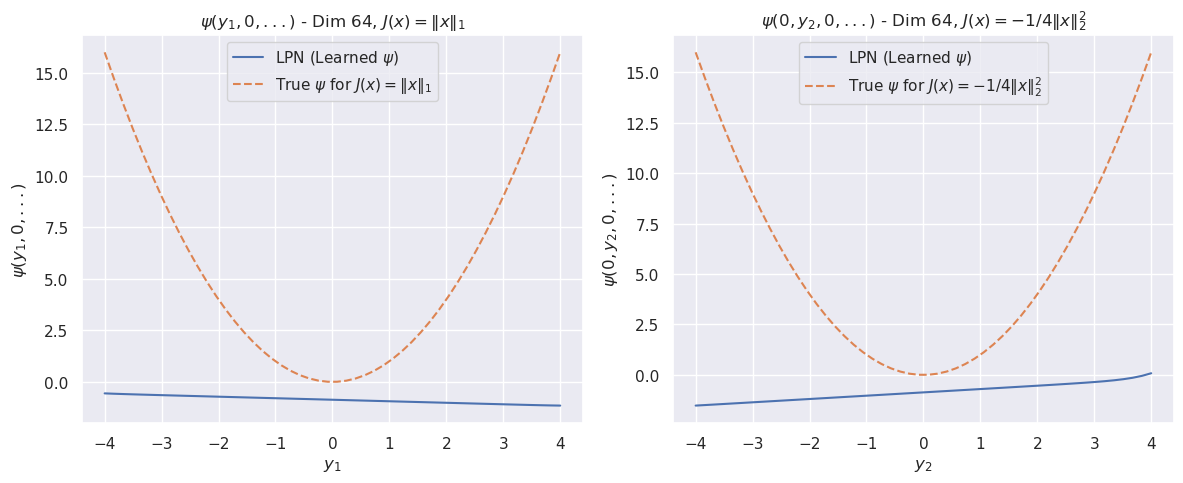

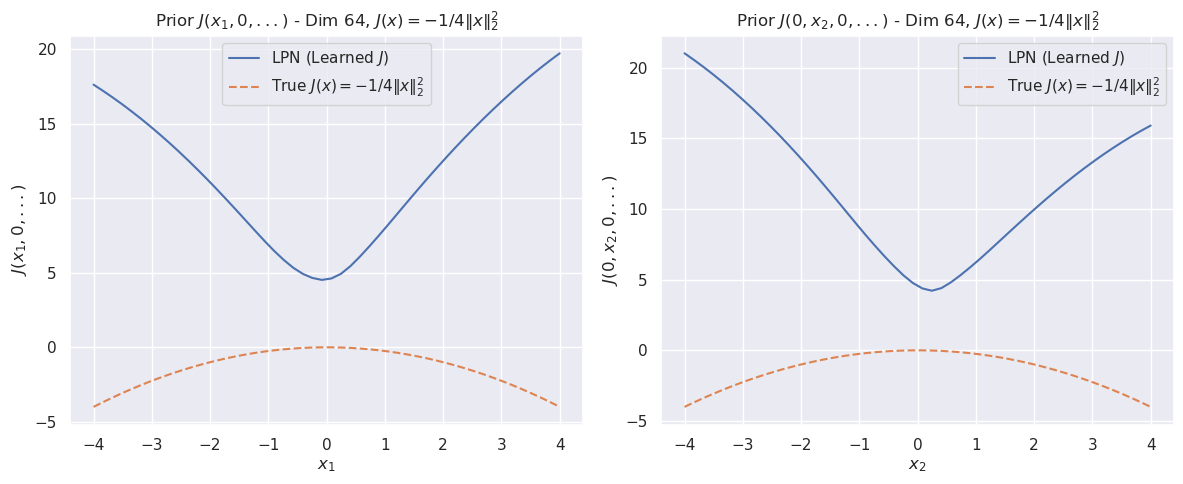

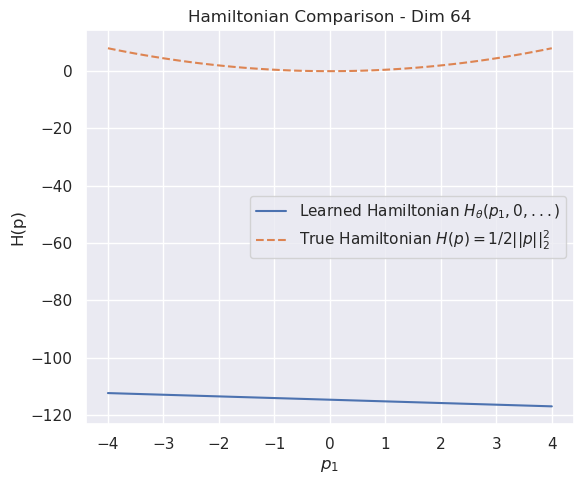

In [8]:
#print("\n--- Plotting Cross Sections for Quadratic H, Concave Quad Prior (Dim=4) ---")
plot_all_concave_quad(lpn_model_concave_quad_l2, a_exp, spacing, INVERT_MODE, dim_exp)

#print("\n--- Plotting Learned Hamiltonian for Quadratic H, Concave Quad Prior ---")
evaluate_learned_H(lpn_model_concave_quad_l2, a_exp, spacing, dim_exp)

Generated G samples: G_samples_tensor shape torch.Size([20000, 1])

--- Plotting Updated Prior j_hat(y) (Dim=64) ---


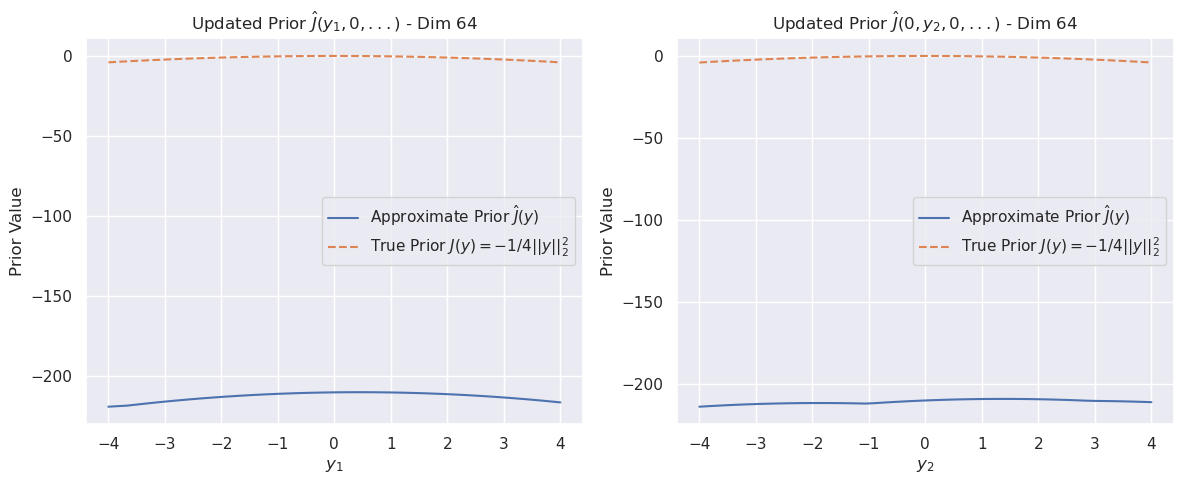

In [9]:
# --- Generate New Training Data for the Second LPN G(x) ---
# We use the same x_j_exp_tensor as the first LPN's training data for x_k
x_k_tensor = y_j_exp_tensor.clone().to(device)
x_k_tensor.requires_grad_(True)

# 1. Compute the gradient y_k = grad_x psi_theta(x_k, t=1)
# Get psi(x_k)
psi_x_k = lpn_model_concave_quad_l2.scalar(x_k_tensor)

# Get gradient y_k = grad_psi(x_k)
y_k_tensor = lpn_model_concave_quad_l2(x_k_tensor)

# 2. Evaluate the "new" samples G_k = <y_k, x_k> - psi_theta(x_k, 1) (from eq 26)
inner_prod_yk_xk = torch.sum(y_k_tensor * x_k_tensor, dim=1, keepdim=True)
G_samples_tensor_with_graph = inner_prod_yk_xk - psi_x_k

# Detach the tensor to treat G_k as fixed targets, breaking the connection
# to the first LPN's graph and preventing the RuntimeError during training.
G_samples_tensor = G_samples_tensor_with_graph.detach().to(device) 

# The input tensor x_k_tensor is still needed for the second LPN training,
# but it should also not require a gradient for that training.
x_k_tensor = x_k_tensor.detach()
x_k_tensor.requires_grad_(False) 
y_k_tensor = y_k_tensor.detach()
y_k_tensor.requires_grad_(False)
# G_samples_tensor now holds the target values G_k
print(f"Generated G samples: G_samples_tensor shape {G_samples_tensor.shape}")


# def evaluate_updated_prior_J_hat(y_points, model, x_k_np):
#     """
#     Implements the approximate prior.
#     """
    
#     # Pre-compute y_k = grad psi(x_k) from the training data
#     x_k_tensor = torch.from_numpy(x_k_np).float().to(device)
#     y_k_tensor = model(x_k_tensor)
#     y_k_np = y_k_tensor.detach().cpu().numpy()
    
#     # Compute S(x_k, 1) = psi(x_k, t=1) from the LPN
#     S_x_k = model.scalar(x_k_tensor)  # Shape (K, 1)
#     S_x_k_np = S_x_k.detach().cpu().numpy().flatten()  # Shape (K,)
    
#     # The constant term simplifies to just S(x_k, 1)
#     # Because: J_tilde(y_k) + 1/2||x_k - y_k||^2 
#     #        = [S(x_k,1) - 1/2||x_k - y_k||^2] + 1/2||x_k - y_k||^2 
#     #        = S(x_k, 1)
#     constants_k = S_x_k_np  # Shape (K,)
    
#     # Term 3: -1/2 * ||x_k - y||^2
#     # Broadcasting: x_k_np (K, 1, dim), y_points (1, N, dim) -> (K, N)
#     term3 = -0.5 * np.sum((x_k_np[:, np.newaxis, :] - y_points[np.newaxis, :, :])**2, axis=2)
    
#     # Term 4: 1/4 * ||y - y_k||^2
#     # Broadcasting: y_points (1, N, dim), y_k_np (K, 1, dim) -> (K, N)
#     term4 = 0.25 * np.sum((y_points[np.newaxis, :, :] - y_k_np[:, np.newaxis, :])**2, axis=2)

#     term5 = 0.5 * np.sum((x_k_np[:, np.newaxis, :])**2, axis=2)
#     all_terms = term5 - constants_k[:, np.newaxis] + term3 
    
#     # # Combine all terms: constants_k (K, 1) + term3 (K, N) + term4 (K, N)
#     # all_terms = constants_k[:, np.newaxis] + term3 + term4
    
#     # Take the max over K dimension
#     j_hat_est = np.max(all_terms, axis=0)
    
#     return j_hat_est

# def plot_updated_prior_J_hat(model, a, spacing, dim, x_k_np):
#     """
#     Generates cross-section plots for the prior j_hat(y) from the "Update".
#     """
#     print(f"\n--- Plotting Updated Prior j_hat(y) (Dim={dim}) ---")
#     xi, y1_0_points, y2_0_points = compute_square_cross_sections(a, spacing, dim)

#     # Compute true prior J(y)
#     y1_0_J_true = prior_true_concave_quad(y1_0_points)
    
#     # Compute estimated prior j_hat(y)
#     y1_0_J_hat_est = evaluate_updated_prior_J_hat(y1_0_points, model, x_k_np)

#     plt.figure(figsize=(12, 5))
    
#     plt.subplot(1, 2, 1)
#     plt.plot(xi, y1_0_J_hat_est, "-", label="Approximate Prior $\\hat{J}(y)$")
#     plt.plot(xi, y1_0_J_true, "--", label="True Prior $J(y)=-1/4||y||_2^2$")
#     plt.grid(True)
#     plt.title(f"Updated Prior $\\hat{{J}}(y_1,0,...)$ - Dim {dim}")
#     plt.xlabel('$y_1$')
#     plt.ylabel('Prior Value')
#     plt.legend()

#     if dim > 1:
#         y2_0_J_true = prior_true_concave_quad(y2_0_points)
#         y2_0_J_hat_est = evaluate_updated_prior_J_hat(y2_0_points, model, x_k_np)
        
#         plt.subplot(1, 2, 2)
#         plt.plot(xi, y2_0_J_hat_est, "-", label="Approximate Prior $\\hat{J}(y)$")
#         plt.plot(xi, y2_0_J_true, "--", label="True Prior $J(y)=-1/4||y||_2^2$")
#         plt.grid(True)
#         plt.title(f"Updated Prior $\\hat{{J}}(0,y_2,0,...)$ - Dim {dim}")
#         plt.xlabel('$y_2$')
#         plt.ylabel('Prior Value')
#         plt.legend()
        
#     plt.tight_layout()
#     plt.show()


# # We use the original training data 'x_j_exp_np' as our set of x_k points.
# #subset_size = 1000 
# x_k_subset_np = y_j_exp_np#[:subset_size, :]

# plot_updated_prior_J_hat(lpn_model_concave_quad_l2, a_exp, spacing, dim_exp, x_k_subset_np)


In [10]:
# --- Step 3: Train LPN G(x) ---
print("\n--- Training Second LPN G(x) for Concave Quadratic Prior ---")
# The target for this LPN is G_samples_tensor
# The input for this LPN is x_k_tensor
lpn_model_G = LPN(in_dim=dim_exp, hidden=hidden, layers=layers, beta=beta, eps=1e-3).to(device)
optimizer_G = torch.optim.Adam(lpn_model_G.parameters(), lr=1e-4)

# Initial shorter training phase
for i in range(1):
     single_iteration(i, data_points_exp, lpn_model_G, optimizer_G, y_k_tensor, G_samples_tensor, loss_type=2, gamma_loss=None)

for g in optimizer_G.param_groups:
    g["lr"] = 1e-4 # Use a smaller learning rate for the long phase
for i in range(iterations_exp_long):
    if (i % 20000 == 0) and (i > 0): 
        # Multiply the current learning rate by 1e-1
        for g in optimizer_G.param_groups:
            new_lr = g["lr"] * 1e-1
            g["lr"] = new_lr
        print(f"Learning rate decreased to {new_lr} at iteration {i}")
    single_iteration(i, data_points_exp, lpn_model_G, optimizer_G, y_k_tensor, G_samples_tensor, loss_type=2, gamma_loss=None)

torch.save(lpn_model_G.state_dict(), os.path.join(MODEL_DIR, "G_network_l2.pth"))
print("Training of LPN for G(x) complete and model saved.")


--- Training Second LPN G(x) for Concave Quadratic Prior ---
iteration 0 loss 67385.953125
iteration 0 loss 51840.48046875


iteration 500 loss 514.2688598632812


iteration 1000 loss 346.3752746582031


iteration 1500 loss 242.8802947998047


iteration 2000 loss 178.315673828125


iteration 2500 loss 136.84034729003906


iteration 3000 loss 109.7694320678711


iteration 3500 loss 92.0428237915039


iteration 4000 loss 80.12041473388672


iteration 4500 loss 71.50419616699219


iteration 5000 loss 64.77897644042969


iteration 5500 loss 59.1677360534668


iteration 6000 loss 54.34568786621094


iteration 6500 loss 50.01052474975586


iteration 7000 loss 46.038822174072266


iteration 7500 loss 42.372535705566406


iteration 8000 loss 38.9959602355957


iteration 8500 loss 35.933509826660156


iteration 9000 loss 33.03184127807617


iteration 9500 loss 30.3077392578125


iteration 10000 loss 27.61504364013672


iteration 10500 loss 25.132915496826172


iteration 11000 loss 22.88228988647461


iteration 11500 loss 20.833078384399414


iteration 12000 loss 18.915634155273438


iteration 12500 loss 17.303274154663086


iteration 13000 loss 15.984659194946289


iteration 13500 loss 14.952498435974121


iteration 14000 loss 14.173863410949707


iteration 14500 loss 13.520415306091309


iteration 15000 loss 12.99424934387207


iteration 15500 loss 12.56723403930664


iteration 16000 loss 12.175844192504883


iteration 16500 loss 11.82055377960205


iteration 17000 loss 11.456263542175293


iteration 17500 loss 11.135066986083984


iteration 18000 loss 10.885232925415039


iteration 18500 loss 10.616071701049805


iteration 19000 loss 10.414772033691406


iteration 19500 loss 10.212019920349121


iteration 20000 loss 10.009541511535645


iteration 20500 loss 9.836142539978027


iteration 21000 loss 9.681903839111328


iteration 21500 loss 9.524517059326172


iteration 22000 loss 9.388398170471191


iteration 22500 loss 9.2581205368042


iteration 23000 loss 9.136423110961914


iteration 23500 loss 9.021528244018555


iteration 24000 loss 8.925292015075684


iteration 24500 loss 8.82259464263916


iteration 25000 loss 8.746963500976562


iteration 25500 loss 8.68458366394043


iteration 26000 loss 8.579948425292969


iteration 26500 loss 8.50170612335205


iteration 27000 loss 8.433610916137695


iteration 27500 loss 8.369104385375977


iteration 28000 loss 8.31300163269043


iteration 28500 loss 8.249990463256836


iteration 29000 loss 8.195565223693848


iteration 29500 loss 8.14188289642334


iteration 30000 loss 8.092795372009277


iteration 30500 loss 8.042377471923828


iteration 31000 loss 8.003159523010254


iteration 31500 loss 7.954545974731445


iteration 32000 loss 7.916593551635742


iteration 32500 loss 7.873124122619629


iteration 33000 loss 7.836546897888184


iteration 33500 loss 7.801565647125244


iteration 34000 loss 7.764776229858398


iteration 34500 loss 7.73488712310791


iteration 35000 loss 7.6993231773376465


iteration 35500 loss 7.668848991394043


iteration 36000 loss 7.638376235961914


iteration 36500 loss 7.603263854980469


iteration 37000 loss 7.574741840362549


iteration 37500 loss 7.5387444496154785


iteration 38000 loss 7.513155460357666


iteration 38500 loss 7.481688976287842


iteration 39000 loss 7.448850631713867


iteration 39500 loss 7.418610572814941


iteration 40000 loss 7.387444972991943


iteration 40500 loss 7.363226413726807


iteration 41000 loss 7.33328104019165


iteration 41500 loss 7.309455394744873


iteration 42000 loss 7.28350830078125


iteration 42500 loss 7.259054660797119


iteration 43000 loss 7.2360076904296875


iteration 43500 loss 7.210947513580322


iteration 44000 loss 7.190323352813721


iteration 44500 loss 7.164207458496094


iteration 45000 loss 7.144287109375


iteration 45500 loss 7.121152400970459


iteration 46000 loss 7.098663330078125


iteration 46500 loss 7.081500053405762


iteration 47000 loss 7.0605950355529785


iteration 47500 loss 7.043829441070557


iteration 48000 loss 7.025853633880615


iteration 48500 loss 7.006731986999512


iteration 49000 loss 6.991066932678223


iteration 49500 loss 6.971714496612549


iteration 50000 loss 6.955968379974365


iteration 50500 loss 6.940832614898682


iteration 51000 loss 6.928163051605225


iteration 51500 loss 6.907890319824219


iteration 52000 loss 6.891021728515625


iteration 52500 loss 6.874849796295166


iteration 53000 loss 6.861179351806641


iteration 53500 loss 6.844780445098877


iteration 54000 loss 6.833970069885254


iteration 54500 loss 6.821259021759033


iteration 55000 loss 6.805396556854248


iteration 55500 loss 6.79381799697876


iteration 56000 loss 6.7814483642578125


iteration 56500 loss 6.765711784362793


iteration 57000 loss 6.754539489746094


iteration 57500 loss 6.741941928863525


iteration 58000 loss 6.733023166656494


iteration 58500 loss 6.716860771179199


iteration 59000 loss 6.704877853393555


iteration 59500 loss 6.694694995880127


iteration 60000 loss 6.6816582679748535


iteration 60500 loss 6.670410633087158


iteration 61000 loss 6.694506645202637


iteration 61500 loss 6.646806716918945


iteration 62000 loss 6.634243488311768


iteration 62500 loss 6.622541904449463


iteration 63000 loss 6.613718032836914


iteration 63500 loss 6.602448463439941


iteration 64000 loss 6.58954381942749


iteration 64500 loss 6.580806255340576


iteration 65000 loss 6.569740295410156


iteration 65500 loss 6.698177814483643


iteration 66000 loss 6.547350883483887


iteration 66500 loss 6.537013530731201


iteration 67000 loss 6.5240983963012695


iteration 67500 loss 6.515263557434082


iteration 68000 loss 6.50394344329834


iteration 68500 loss 6.4874677658081055


iteration 69000 loss 6.472087860107422


iteration 69500 loss 6.456752777099609


iteration 70000 loss 6.4400811195373535


iteration 70500 loss 6.426016330718994


iteration 71000 loss 6.414259433746338


iteration 71500 loss 6.400211811065674


iteration 72000 loss 6.386520862579346


iteration 72500 loss 6.3727312088012695


iteration 73000 loss 6.355898857116699


iteration 73500 loss 6.341201305389404


iteration 74000 loss 6.330381870269775


iteration 74500 loss 6.317862510681152


iteration 75000 loss 6.305761337280273


iteration 75500 loss 6.297178745269775


iteration 76000 loss 6.286377906799316


iteration 76500 loss 6.274267673492432


iteration 77000 loss 6.266980171203613


iteration 77500 loss 6.258188724517822


iteration 78000 loss 6.247403621673584


iteration 78500 loss 6.239003658294678


iteration 79000 loss 6.230111598968506


iteration 79500 loss 6.22113037109375


iteration 80000 loss 6.212055206298828


iteration 80500 loss 6.204187393188477


iteration 81000 loss 6.1930036544799805


iteration 81500 loss 6.183948516845703


iteration 82000 loss 6.173381328582764


iteration 82500 loss 6.1592535972595215


iteration 83000 loss 6.149453639984131


iteration 83500 loss 6.141168117523193


iteration 84000 loss 6.130908012390137


iteration 84500 loss 6.118515491485596


iteration 85000 loss 6.1115522384643555


iteration 85500 loss 6.102476596832275


iteration 86000 loss 6.091290473937988


iteration 86500 loss 6.082329750061035


iteration 87000 loss 6.073514461517334


iteration 87500 loss 6.0631537437438965


iteration 88000 loss 6.055069923400879


iteration 88500 loss 6.0471649169921875


iteration 89000 loss 6.03780460357666


iteration 89500 loss 6.027141094207764


iteration 90000 loss 6.021177768707275


iteration 90500 loss 6.014288902282715


iteration 91000 loss 6.006191253662109


iteration 91500 loss 6.000857830047607


iteration 92000 loss 5.995142936706543


iteration 92500 loss 5.987700462341309


iteration 93000 loss 5.979405879974365


iteration 93500 loss 5.97295618057251


iteration 94000 loss 5.964914798736572


iteration 94500 loss 5.960821628570557


iteration 95000 loss 5.947610378265381


iteration 95500 loss 5.934420108795166


iteration 96000 loss 5.914736747741699


iteration 96500 loss 5.90090274810791


iteration 97000 loss 5.8853631019592285


iteration 97500 loss 5.865469455718994


iteration 98000 loss 5.852499961853027


iteration 98500 loss 5.841695308685303


iteration 99000 loss 5.829736709594727


iteration 99500 loss 5.816012859344482


iteration 100000 loss 5.8056864738464355


iteration 100500 loss 5.793097496032715


iteration 101000 loss 5.7773237228393555


iteration 101500 loss 5.766707420349121


iteration 102000 loss 5.756293773651123


iteration 102500 loss 5.743527412414551


iteration 103000 loss 5.731104373931885


iteration 103500 loss 5.722056865692139


iteration 104000 loss 5.708258628845215


iteration 104500 loss 5.689366340637207


iteration 105000 loss 5.676956653594971


iteration 105500 loss 5.6657843589782715


iteration 106000 loss 5.652255535125732


iteration 106500 loss 5.674219608306885


iteration 107000 loss 5.625301361083984


iteration 107500 loss 5.612183570861816


iteration 108000 loss 5.592378616333008


iteration 108500 loss 5.5728936195373535


iteration 109000 loss 5.555960178375244


iteration 109500 loss 5.534630298614502


iteration 110000 loss 5.513486385345459


iteration 110500 loss 5.499922752380371


iteration 111000 loss 5.4811625480651855


iteration 111500 loss 5.455947399139404


iteration 112000 loss 5.435957908630371


iteration 112500 loss 5.414098739624023


iteration 113000 loss 5.380027770996094


iteration 113500 loss 5.348187446594238


iteration 114000 loss 5.3262505531311035


iteration 114500 loss 5.297278881072998


iteration 115000 loss 5.259878158569336


iteration 115500 loss 5.2308783531188965


iteration 116000 loss 5.206815719604492


iteration 116500 loss 5.17685079574585


iteration 117000 loss 5.13869047164917


iteration 117500 loss 5.113146781921387


iteration 118000 loss 5.078298091888428


iteration 118500 loss 5.030697345733643


iteration 119000 loss 4.989567756652832


iteration 119500 loss 4.946669578552246


iteration 120000 loss 4.889931678771973


iteration 120500 loss 4.830886363983154


iteration 121000 loss 4.786838054656982


iteration 121500 loss 4.738272666931152


iteration 122000 loss 4.678101062774658


iteration 122500 loss 4.633668422698975


iteration 123000 loss 4.59196138381958


iteration 123500 loss 4.538534164428711


iteration 124000 loss 4.479200839996338


iteration 124500 loss 4.437458038330078


iteration 125000 loss 4.392444133758545


iteration 125500 loss 4.340675354003906


iteration 126000 loss 4.281056880950928


iteration 126500 loss 4.241103649139404


iteration 127000 loss 4.193597316741943


iteration 127500 loss 4.12883186340332


iteration 128000 loss 4.054445266723633


iteration 128500 loss 4.000789165496826


iteration 129000 loss 3.9359779357910156


iteration 129500 loss 3.8626346588134766


iteration 130000 loss 3.8085105419158936


iteration 130500 loss 3.7647273540496826


iteration 131000 loss 3.7091376781463623


iteration 131500 loss 3.6427078247070312


iteration 132000 loss 3.5915589332580566


iteration 132500 loss 3.5431554317474365


iteration 133000 loss 3.4880003929138184


iteration 133500 loss 3.425377368927002


iteration 134000 loss 3.388775587081909


iteration 134500 loss 3.347268581390381


iteration 135000 loss 3.2997796535491943


iteration 135500 loss 3.249737501144409


iteration 136000 loss 3.2210888862609863


iteration 136500 loss 3.1857736110687256


iteration 137000 loss 3.143376588821411


iteration 137500 loss 3.09578275680542


iteration 138000 loss 3.069474220275879


iteration 138500 loss 3.039593458175659


iteration 139000 loss 3.0053765773773193


iteration 139500 loss 2.967153310775757


iteration 140000 loss 2.9460959434509277


iteration 140500 loss 2.9213600158691406


iteration 141000 loss 2.8930249214172363


iteration 141500 loss 2.8616390228271484


iteration 142000 loss 2.8454267978668213


iteration 142500 loss 2.8258862495422363


iteration 143000 loss 2.8024566173553467


iteration 143500 loss 2.800525426864624


iteration 144000 loss 2.7626278400421143


iteration 144500 loss 2.745159387588501


iteration 145000 loss 2.724470615386963


iteration 145500 loss 2.7063539028167725


iteration 146000 loss 2.6933302879333496


iteration 146500 loss 2.678591012954712


iteration 147000 loss 2.659759759902954


iteration 147500 loss 2.647111177444458


iteration 148000 loss 2.6361021995544434


iteration 148500 loss 2.6223855018615723


iteration 149000 loss 2.60548734664917


iteration 149500 loss 2.591684341430664


iteration 150000 loss 2.581603527069092


iteration 150500 loss 2.568955421447754


iteration 151000 loss 2.554469585418701


iteration 151500 loss 2.541335344314575


iteration 152000 loss 2.532489776611328


iteration 152500 loss 2.5213334560394287


iteration 153000 loss 2.507598876953125


iteration 153500 loss 2.496913194656372


iteration 154000 loss 2.4893898963928223


iteration 154500 loss 2.479841709136963


iteration 155000 loss 2.4681594371795654


iteration 155500 loss 2.456941843032837


iteration 156000 loss 2.4501278400421143


iteration 156500 loss 2.4416491985321045


iteration 157000 loss 2.4314656257629395


iteration 157500 loss 2.41911244392395


iteration 158000 loss 2.4122326374053955


iteration 158500 loss 2.404364824295044


iteration 159000 loss 2.394373655319214


iteration 159500 loss 2.3817636966705322


iteration 160000 loss 2.3726861476898193


iteration 160500 loss 2.364375352859497


iteration 161000 loss 2.3540127277374268


iteration 161500 loss 2.342107057571411


iteration 162000 loss 2.3353004455566406


iteration 162500 loss 2.3280365467071533


iteration 163000 loss 2.318880319595337


iteration 163500 loss 2.3084793090820312


iteration 164000 loss 2.3027634620666504


iteration 164500 loss 2.2968850135803223


iteration 165000 loss 2.2896482944488525


iteration 165500 loss 2.2803256511688232


iteration 166000 loss 2.2719922065734863


iteration 166500 loss 2.266683578491211


iteration 167000 loss 2.2599689960479736


iteration 167500 loss 2.251920223236084


iteration 168000 loss 2.2442984580993652


iteration 168500 loss 2.2393367290496826


iteration 169000 loss 2.233011484146118


iteration 169500 loss 2.225536584854126


iteration 170000 loss 2.21669340133667


iteration 170500 loss 2.212538719177246


iteration 171000 loss 2.2075791358947754


iteration 171500 loss 2.2012767791748047


iteration 172000 loss 2.1937191486358643


iteration 172500 loss 2.188530921936035


iteration 173000 loss 2.18432879447937


iteration 173500 loss 2.1791064739227295


iteration 174000 loss 2.172360420227051


iteration 174500 loss 2.166727304458618


iteration 175000 loss 2.163304328918457


iteration 175500 loss 2.159015417098999


iteration 176000 loss 2.1533846855163574


iteration 176500 loss 2.146228075027466


iteration 177000 loss 2.141819953918457


iteration 177500 loss 2.1376960277557373


iteration 178000 loss 2.1327810287475586


iteration 178500 loss 2.1269986629486084


iteration 179000 loss 2.121840476989746


iteration 179500 loss 2.11889386177063


iteration 180000 loss 2.115239381790161


iteration 180500 loss 2.1111128330230713


iteration 181000 loss 2.104750633239746


iteration 181500 loss 2.1018502712249756


iteration 182000 loss 2.0986859798431396


iteration 182500 loss 2.094618797302246


iteration 183000 loss 2.0907411575317383


iteration 183500 loss 2.0852901935577393


iteration 184000 loss 2.0824952125549316


iteration 184500 loss 2.078922986984253


iteration 185000 loss 2.0743086338043213


iteration 185500 loss 2.195449113845825


iteration 186000 loss 2.0661261081695557


iteration 186500 loss 2.062706232070923


iteration 187000 loss 2.0581741333007812


iteration 187500 loss 2.0533463954925537


iteration 188000 loss 2.050503969192505


iteration 188500 loss 2.0472145080566406


iteration 189000 loss 2.0431909561157227


iteration 189500 loss 2.368534803390503


iteration 190000 loss 2.035977602005005


iteration 190500 loss 2.033416271209717


iteration 191000 loss 2.030160903930664


iteration 191500 loss 2.02656888961792


iteration 192000 loss 2.0226335525512695


iteration 192500 loss 2.0206403732299805


iteration 193000 loss 2.0182392597198486


iteration 193500 loss 2.0152225494384766


iteration 194000 loss 2.0114967823028564


iteration 194500 loss 2.008780002593994


iteration 195000 loss 2.0064778327941895


iteration 195500 loss 2.0035037994384766


iteration 196000 loss 1.9999065399169922


iteration 196500 loss 1.996389389038086


iteration 197000 loss 1.9941511154174805


iteration 197500 loss 1.9912978410720825


iteration 198000 loss 1.9875874519348145


iteration 198500 loss 1.9843089580535889


iteration 199000 loss 1.9822419881820679


iteration 199500 loss 1.9797526597976685


iteration 200000 loss 1.9766632318496704


iteration 200500 loss 1.9729417562484741


iteration 201000 loss 1.9705610275268555


iteration 201500 loss 1.9681174755096436


iteration 202000 loss 1.9652304649353027


iteration 202500 loss 1.9611585140228271


iteration 203000 loss 1.9594684839248657


iteration 203500 loss 1.9575542211532593


iteration 204000 loss 1.95516836643219


iteration 204500 loss 1.9522634744644165


iteration 205000 loss 1.9487396478652954


iteration 205500 loss 1.9469738006591797


iteration 206000 loss 1.944943904876709


iteration 206500 loss 1.9427409172058105


iteration 207000 loss 1.9393489360809326


iteration 207500 loss 1.9371962547302246


iteration 208000 loss 1.9356476068496704


iteration 208500 loss 1.9337066411972046


iteration 209000 loss 1.9312987327575684


iteration 209500 loss 1.9281854629516602


iteration 210000 loss 1.9263375997543335


iteration 210500 loss 1.9242069721221924


iteration 211000 loss 1.9215421676635742


iteration 211500 loss 2.3527612686157227


iteration 212000 loss 1.916933298110962


iteration 212500 loss 1.9152805805206299


iteration 213000 loss 1.9132047891616821


iteration 213500 loss 1.9105960130691528


iteration 214000 loss 1.9079022407531738


iteration 214500 loss 1.9062726497650146


iteration 215000 loss 1.9043753147125244


iteration 215500 loss 1.901987075805664


iteration 216000 loss 1.899046778678894


iteration 216500 loss 1.8973156213760376


iteration 217000 loss 1.8955060243606567


iteration 217500 loss 1.8933002948760986


iteration 218000 loss 1.890500783920288


iteration 218500 loss 1.888885736465454


iteration 219000 loss 1.887557029724121


iteration 219500 loss 1.8859074115753174


iteration 220000 loss 1.8838350772857666


iteration 220500 loss 1.8812198638916016


iteration 221000 loss 1.8799571990966797


iteration 221500 loss 1.8786468505859375


iteration 222000 loss 1.8769880533218384


iteration 222500 loss 1.874893069267273


iteration 223000 loss 1.8722362518310547


iteration 223500 loss 1.870987057685852


iteration 224000 loss 1.8696430921554565


iteration 224500 loss 1.8679382801055908


iteration 225000 loss 1.8657864332199097


iteration 225500 loss 1.8636738061904907


iteration 226000 loss 1.8624558448791504


iteration 226500 loss 1.861075520515442


iteration 227000 loss 1.8592872619628906


iteration 227500 loss 1.8570349216461182


iteration 228000 loss 1.85531747341156


iteration 228500 loss 1.8540464639663696


iteration 229000 loss 1.8524893522262573


iteration 229500 loss 1.8508530855178833


iteration 230000 loss 1.8480592966079712


iteration 230500 loss 1.8468984365463257


iteration 231000 loss 1.8457071781158447


iteration 231500 loss 1.8442047834396362


iteration 232000 loss 1.8423683643341064


iteration 232500 loss 1.839773416519165


iteration 233000 loss 1.8385237455368042


iteration 233500 loss 1.8372163772583008


iteration 234000 loss 1.8355480432510376


iteration 234500 loss 1.833553671836853


iteration 235000 loss 1.8310973644256592


iteration 235500 loss 1.8298150300979614


iteration 236000 loss 1.8286136388778687


iteration 236500 loss 1.8271452188491821


iteration 237000 loss 1.8253071308135986


iteration 237500 loss 1.823035478591919


iteration 238000 loss 1.8219282627105713


iteration 238500 loss 1.820640206336975


iteration 239000 loss 1.8189985752105713


iteration 239500 loss 1.8169349431991577


iteration 240000 loss 1.8154535293579102


iteration 240500 loss 1.8141717910766602


iteration 241000 loss 1.8125718832015991


iteration 241500 loss 1.8105906248092651


iteration 242000 loss 1.809063196182251


iteration 242500 loss 1.8079925775527954


iteration 243000 loss 1.8067221641540527


iteration 243500 loss 1.805233359336853


iteration 244000 loss 1.805127739906311


iteration 244500 loss 1.802039384841919


iteration 245000 loss 1.8007292747497559


iteration 245500 loss 1.7991700172424316


iteration 246000 loss 6.159622669219971


iteration 246500 loss 1.7961528301239014


iteration 247000 loss 1.7950159311294556


iteration 247500 loss 1.7935552597045898


iteration 248000 loss 1.791711688041687


iteration 248500 loss 1.790054202079773


iteration 249000 loss 1.7890552282333374


iteration 249500 loss 1.787888765335083


iteration 250000 loss 1.786412239074707


iteration 250500 loss 1.7845942974090576


iteration 251000 loss 1.7831264734268188


iteration 251500 loss 1.7821238040924072


iteration 252000 loss 1.7808952331542969


iteration 252500 loss 1.7804478406906128


iteration 253000 loss 1.7775765657424927


iteration 253500 loss 1.7765254974365234


iteration 254000 loss 1.7756550312042236


iteration 254500 loss 1.774535894393921


iteration 255000 loss 1.7731866836547852


iteration 255500 loss 1.7712386846542358


iteration 256000 loss 1.769741177558899


iteration 256500 loss 1.7686152458190918


iteration 257000 loss 1.7672566175460815


iteration 257500 loss 1.7655819654464722


iteration 258000 loss 1.7641363143920898


iteration 258500 loss 1.7629362344741821


iteration 259000 loss 1.7618435621261597


iteration 259500 loss 1.7606950998306274


iteration 260000 loss 1.7588160037994385


iteration 260500 loss 1.7575011253356934


iteration 261000 loss 1.7566304206848145


iteration 261500 loss 1.7555553913116455


iteration 262000 loss 1.7549128532409668


iteration 262500 loss 1.7524069547653198


iteration 263000 loss 1.75141441822052


iteration 263500 loss 1.750573992729187


iteration 264000 loss 1.7495155334472656


iteration 264500 loss 1.7481895685195923


iteration 265000 loss 1.7463661432266235


iteration 265500 loss 1.7453901767730713


iteration 266000 loss 1.7442713975906372


iteration 266500 loss 1.7431972026824951


iteration 267000 loss 1.7411268949508667


iteration 267500 loss 1.7401365041732788


iteration 268000 loss 1.7391124963760376


iteration 268500 loss 1.7378894090652466


iteration 269000 loss 1.7364521026611328


iteration 269500 loss 1.7346981763839722


iteration 270000 loss 1.73370361328125


iteration 270500 loss 1.7327200174331665


iteration 271000 loss 1.7314913272857666


iteration 271500 loss 1.7299509048461914


iteration 272000 loss 1.728804588317871


iteration 272500 loss 1.727990746498108


iteration 273000 loss 1.7272136211395264


iteration 273500 loss 1.726239800453186


iteration 274000 loss 1.7250010967254639


iteration 274500 loss 1.724249005317688


iteration 275000 loss 1.7226811647415161


iteration 275500 loss 1.7217671871185303


iteration 276000 loss 1.7206206321716309


iteration 276500 loss 1.7192269563674927


iteration 277000 loss 1.7183042764663696


iteration 277500 loss 1.7176214456558228


iteration 278000 loss 1.7168190479278564


iteration 278500 loss 1.715794324874878


iteration 279000 loss 1.7151494026184082


iteration 279500 loss 1.7136032581329346


iteration 280000 loss 1.7125595808029175


iteration 280500 loss 1.7118374109268188


iteration 281000 loss 1.7109663486480713


iteration 281500 loss 1.7098487615585327


iteration 282000 loss 1.7081950902938843


iteration 282500 loss 1.70732843875885


iteration 283000 loss 1.7065659761428833


iteration 283500 loss 1.7056145668029785


iteration 284000 loss 1.7045764923095703


iteration 284500 loss 1.7029093503952026


iteration 285000 loss 1.702091932296753


iteration 285500 loss 1.7013792991638184


iteration 286000 loss 1.7005000114440918


iteration 286500 loss 1.6993921995162964


iteration 287000 loss 1.6980684995651245


iteration 287500 loss 1.69681715965271


iteration 288000 loss 1.6959919929504395


iteration 288500 loss 1.694997787475586


iteration 289000 loss 1.6937755346298218


iteration 289500 loss 1.6924296617507935


iteration 290000 loss 1.6913601160049438


iteration 290500 loss 1.6905301809310913


iteration 291000 loss 1.6898053884506226


iteration 291500 loss 1.688167691230774


iteration 292000 loss 1.687050700187683


iteration 292500 loss 1.6862022876739502


iteration 293000 loss 1.6852542161941528


iteration 293500 loss 1.6840606927871704


iteration 294000 loss 1.689128041267395


iteration 294500 loss 1.6821030378341675


iteration 295000 loss 1.6813714504241943


iteration 295500 loss 1.6804858446121216


iteration 296000 loss 1.679414987564087


iteration 296500 loss 1.6779425144195557


iteration 297000 loss 1.6772644519805908


iteration 297500 loss 1.6765706539154053


iteration 298000 loss 1.6757267713546753


iteration 298500 loss 1.6747891902923584


iteration 299000 loss 1.6733150482177734


iteration 299500 loss 1.6726404428482056


iteration 300000 loss 1.6719616651535034


iteration 300500 loss 1.6711111068725586


iteration 301000 loss 1.670026183128357


iteration 301500 loss 1.6687638759613037


iteration 302000 loss 1.6681605577468872


iteration 302500 loss 1.6674989461898804


iteration 303000 loss 1.6666609048843384


iteration 303500 loss 1.6655950546264648


iteration 304000 loss 1.6642370223999023


iteration 304500 loss 1.6634929180145264


iteration 305000 loss 1.6627929210662842


iteration 305500 loss 1.6619185209274292


iteration 306000 loss 1.6608351469039917


iteration 306500 loss 1.6594557762145996


iteration 307000 loss 1.658813238143921


iteration 307500 loss 1.6581560373306274


iteration 308000 loss 1.657360315322876


iteration 308500 loss 1.6564042568206787


iteration 309000 loss 1.6550358533859253


iteration 309500 loss 1.654150128364563


iteration 310000 loss 1.653409719467163


iteration 310500 loss 1.6525472402572632


iteration 311000 loss 1.6514556407928467


iteration 311500 loss 1.650147557258606


iteration 312000 loss 1.6493253707885742


iteration 312500 loss 1.6487128734588623


iteration 313000 loss 1.6479860544204712


iteration 313500 loss 1.6470742225646973


iteration 314000 loss 1.6459726095199585


iteration 314500 loss 1.6451538801193237


iteration 315000 loss 1.6439952850341797


iteration 315500 loss 1.6432013511657715


iteration 316000 loss 1.642251968383789


iteration 316500 loss 1.6409469842910767


iteration 317000 loss 1.6403415203094482


iteration 317500 loss 1.639711618423462


iteration 318000 loss 1.638947606086731


iteration 318500 loss 1.638139247894287


iteration 319000 loss 1.6367712020874023


iteration 319500 loss 1.6360715627670288


iteration 320000 loss 1.6353684663772583


iteration 320500 loss 1.6344966888427734


iteration 321000 loss 1.6333943605422974


iteration 321500 loss 1.6324782371520996


iteration 322000 loss 1.631827712059021


iteration 322500 loss 1.6311246156692505


iteration 323000 loss 1.630216360092163


iteration 323500 loss 1.6290861368179321


iteration 324000 loss 1.6281955242156982


iteration 324500 loss 1.627530813217163


iteration 325000 loss 1.6267943382263184


iteration 325500 loss 1.6258734464645386


iteration 326000 loss 1.624708890914917


iteration 326500 loss 1.6241779327392578


iteration 327000 loss 1.6235179901123047


iteration 327500 loss 1.6227413415908813


iteration 328000 loss 1.6216754913330078


iteration 328500 loss 1.6209940910339355


iteration 329000 loss 1.6204280853271484


iteration 329500 loss 1.6198341846466064


iteration 330000 loss 1.6190752983093262


iteration 330500 loss 1.6181294918060303


iteration 331000 loss 6.021276950836182


iteration 331500 loss 1.6166036128997803


iteration 332000 loss 1.6161000728607178


iteration 332500 loss 1.6154818534851074


iteration 333000 loss 1.6149226427078247


iteration 333500 loss 1.6137007474899292


iteration 334000 loss 1.6129636764526367


iteration 334500 loss 1.612345814704895


iteration 335000 loss 1.6117855310440063


iteration 335500 loss 1.611079216003418


iteration 336000 loss 1.6101720333099365


iteration 336500 loss 1.865172028541565


iteration 337000 loss 1.6086211204528809


iteration 337500 loss 1.6080068349838257


iteration 338000 loss 1.60723876953125


iteration 338500 loss 1.6062654256820679


iteration 339000 loss 1.605603814125061


iteration 339500 loss 1.6050422191619873


iteration 340000 loss 1.6045122146606445


iteration 340500 loss 1.6038622856140137


iteration 341000 loss 1.603122591972351


iteration 341500 loss 1.6030503511428833


iteration 342000 loss 1.6014399528503418


iteration 342500 loss 1.6008632183074951


iteration 343000 loss 1.6001577377319336


iteration 343500 loss 1.5994904041290283


iteration 344000 loss 1.598707914352417


iteration 344500 loss 1.598123550415039


iteration 345000 loss 1.5976454019546509


iteration 345500 loss 1.5970501899719238


iteration 346000 loss 1.5964027643203735


iteration 346500 loss 1.5953993797302246


iteration 347000 loss 1.5949325561523438


iteration 347500 loss 1.5945112705230713


iteration 348000 loss 1.5940308570861816


iteration 348500 loss 1.593424916267395


iteration 349000 loss 1.5927015542984009


iteration 349500 loss 1.5920268297195435


iteration 350000 loss 1.5914785861968994


iteration 350500 loss 1.5909240245819092


iteration 351000 loss 1.5902409553527832


iteration 351500 loss 1.5894054174423218


iteration 352000 loss 1.5889439582824707


iteration 352500 loss 1.5884538888931274


iteration 353000 loss 1.5879861116409302


iteration 353500 loss 1.5874407291412354


iteration 354000 loss 1.5873374938964844


iteration 354500 loss 1.5861022472381592


iteration 355000 loss 1.5855826139450073


iteration 355500 loss 1.5850944519042969


iteration 356000 loss 1.585233211517334


iteration 356500 loss 1.5837148427963257


iteration 357000 loss 1.583256483078003


iteration 357500 loss 1.5828551054000854


iteration 358000 loss 1.5823822021484375


iteration 358500 loss 1.5818076133728027


iteration 359000 loss 1.5812416076660156


iteration 359500 loss 1.5806630849838257


iteration 360000 loss 1.580245018005371


iteration 360500 loss 1.5797581672668457


iteration 361000 loss 1.5791443586349487


iteration 361500 loss 1.5789192914962769


iteration 362000 loss 1.5781439542770386


iteration 362500 loss 1.5777920484542847


iteration 363000 loss 1.5774132013320923


iteration 363500 loss 1.57692551612854


iteration 364000 loss 1.5762919187545776


iteration 364500 loss 1.575850486755371


iteration 365000 loss 1.5753462314605713


iteration 365500 loss 1.5749361515045166


iteration 366000 loss 1.5744277238845825


iteration 366500 loss 1.5738346576690674


iteration 367000 loss 1.5734927654266357


iteration 367500 loss 1.5729769468307495


iteration 368000 loss 1.5726314783096313


iteration 368500 loss 1.5722073316574097


iteration 369000 loss 1.5716760158538818


iteration 369500 loss 1.571058750152588


iteration 370000 loss 1.5707430839538574


iteration 370500 loss 1.5703939199447632


iteration 371000 loss 1.570062518119812


iteration 371500 loss 1.5696994066238403


iteration 372000 loss 1.5691777467727661


iteration 372500 loss 1.568474531173706


iteration 373000 loss 1.5682346820831299


iteration 373500 loss 1.5679198503494263


iteration 374000 loss 1.5675435066223145


iteration 374500 loss 1.5670655965805054


iteration 375000 loss 1.5665005445480347


iteration 375500 loss 1.566081166267395


iteration 376000 loss 1.5656485557556152


iteration 376500 loss 1.5652358531951904


iteration 377000 loss 1.5647130012512207


iteration 377500 loss 1.5643796920776367


iteration 378000 loss 1.563826322555542


iteration 378500 loss 1.5635169744491577


iteration 379000 loss 1.5631773471832275


iteration 379500 loss 1.5627515316009521


iteration 380000 loss 1.5622321367263794


iteration 380500 loss 1.5623934268951416


iteration 381000 loss 1.5613915920257568


iteration 381500 loss 1.5610554218292236


iteration 382000 loss 1.5606439113616943


iteration 382500 loss 1.5604169368743896


iteration 383000 loss 1.5595335960388184


iteration 383500 loss 1.5591779947280884


iteration 384000 loss 1.5587741136550903


iteration 384500 loss 1.5584161281585693


iteration 385000 loss 1.5579700469970703


iteration 385500 loss 1.5577247142791748


iteration 386000 loss 1.9989218711853027


iteration 386500 loss 1.5565083026885986


iteration 387000 loss 1.5561648607254028


iteration 387500 loss 1.5557643175125122


iteration 388000 loss 1.5552655458450317


iteration 388500 loss 1.5548056364059448


iteration 389000 loss 1.554334282875061


iteration 389500 loss 1.5538816452026367


iteration 390000 loss 1.5535117387771606


iteration 390500 loss 1.553052306175232


iteration 391000 loss 1.5526279211044312


iteration 391500 loss 1.5521384477615356


iteration 392000 loss 1.5515843629837036


iteration 392500 loss 1.551184058189392


iteration 393000 loss 1.550682783126831


iteration 393500 loss 1.5500470399856567


iteration 394000 loss 1.5497695207595825


iteration 394500 loss 1.5494099855422974


iteration 395000 loss 1.549047827720642


iteration 395500 loss 1.5486677885055542


iteration 396000 loss 1.5482674837112427


iteration 396500 loss 1.5476707220077515


iteration 397000 loss 1.5473473072052002


iteration 397500 loss 1.546990156173706


iteration 398000 loss 1.5465348958969116


iteration 398500 loss 1.5459423065185547


iteration 399000 loss 1.5456417798995972


iteration 399500 loss 1.5452854633331299


iteration 400000 loss 1.544948935508728


iteration 400500 loss 1.544783115386963


iteration 401000 loss 1.544108271598816


iteration 401500 loss 1.543872356414795


iteration 402000 loss 1.5432084798812866


iteration 402500 loss 1.5428645610809326


iteration 403000 loss 1.5424383878707886


iteration 403500 loss 1.5421282052993774


iteration 404000 loss 1.5415903329849243


iteration 404500 loss 1.5410983562469482


iteration 405000 loss 1.540767788887024


iteration 405500 loss 1.5403966903686523


iteration 406000 loss 1.539829134941101


iteration 406500 loss 1.539913535118103


iteration 407000 loss 1.5389991998672485


iteration 407500 loss 1.5386734008789062


iteration 408000 loss 1.5382661819458008


iteration 408500 loss 1.5377517938613892


iteration 409000 loss 1.537515640258789


iteration 409500 loss 1.5369964838027954


iteration 410000 loss 1.5366734266281128


iteration 410500 loss 1.5363433361053467


iteration 411000 loss 1.5359121561050415


iteration 411500 loss 1.7564584016799927


iteration 412000 loss 1.5348833799362183


iteration 412500 loss 1.5345667600631714


iteration 413000 loss 1.5341745615005493


iteration 413500 loss 1.533677339553833


iteration 414000 loss 1.5330373048782349


iteration 414500 loss 1.5327935218811035


iteration 415000 loss 1.532442331314087


iteration 415500 loss 1.532021403312683


iteration 416000 loss 1.5317515134811401


iteration 416500 loss 1.5405809879302979


iteration 417000 loss 1.530701756477356


iteration 417500 loss 1.5304087400436401


iteration 418000 loss 1.5300782918930054


iteration 418500 loss 1.529668927192688


iteration 419000 loss 1.5291589498519897


iteration 419500 loss 1.5295552015304565


iteration 420000 loss 1.52841317653656


iteration 420500 loss 1.5281288623809814


iteration 421000 loss 1.527786135673523


iteration 421500 loss 1.5273412466049194


iteration 422000 loss 1.5271514654159546


iteration 422500 loss 1.5266269445419312


iteration 423000 loss 1.526012897491455


iteration 423500 loss 1.5256752967834473


iteration 424000 loss 1.5252968072891235


iteration 424500 loss 1.5247571468353271


iteration 425000 loss 1.524119257926941


iteration 425500 loss 1.5238298177719116


iteration 426000 loss 1.52346670627594


iteration 426500 loss 1.5230799913406372


iteration 427000 loss 1.5226351022720337


iteration 427500 loss 1.5219937562942505


iteration 428000 loss 1.5216567516326904


iteration 428500 loss 1.521328091621399


iteration 429000 loss 1.520974040031433


iteration 429500 loss 1.5205295085906982


iteration 430000 loss 1.5200560092926025


iteration 430500 loss 1.5199475288391113


iteration 431000 loss 1.5192606449127197


iteration 431500 loss 1.5189588069915771


iteration 432000 loss 1.5186015367507935


iteration 432500 loss 1.5182499885559082


iteration 433000 loss 1.5176613330841064


iteration 433500 loss 1.5173360109329224


iteration 434000 loss 1.5169956684112549


iteration 434500 loss 1.5166912078857422


iteration 435000 loss 1.5163143873214722


iteration 435500 loss 1.515843152999878


iteration 436000 loss 1.5152524709701538


iteration 436500 loss 1.5150293111801147


iteration 437000 loss 1.5147079229354858


iteration 437500 loss 1.5143569707870483


iteration 438000 loss 1.5139166116714478


iteration 438500 loss 1.5134046077728271


iteration 439000 loss 1.5131609439849854


iteration 439500 loss 1.5128835439682007


iteration 440000 loss 1.5125819444656372


iteration 440500 loss 1.5129787921905518


iteration 441000 loss 1.5117220878601074


iteration 441500 loss 1.5120667219161987


iteration 442000 loss 1.510995626449585


iteration 442500 loss 1.5107179880142212


iteration 443000 loss 1.5103751420974731


iteration 443500 loss 1.509939432144165


iteration 444000 loss 1.509377360343933


iteration 444500 loss 1.5091930627822876


iteration 445000 loss 1.508880376815796


iteration 445500 loss 1.5086027383804321


iteration 446000 loss 1.5082553625106812


iteration 446500 loss 1.5078428983688354


iteration 447000 loss 1.5075486898422241


iteration 447500 loss 1.507034182548523


iteration 448000 loss 1.5067417621612549


iteration 448500 loss 1.5064456462860107


iteration 449000 loss 1.5060925483703613


iteration 449500 loss 1.505622386932373


iteration 450000 loss 1.505486249923706


iteration 450500 loss 1.5049363374710083


iteration 451000 loss 1.5046640634536743


iteration 451500 loss 1.5043748617172241


iteration 452000 loss 1.5040156841278076


iteration 452500 loss 1.5038684606552124


iteration 453000 loss 1.50333833694458


iteration 453500 loss 1.502868890762329


iteration 454000 loss 1.502564549446106


iteration 454500 loss 1.502582311630249


iteration 455000 loss 1.5017038583755493


iteration 455500 loss 1.501533031463623


iteration 456000 loss 1.5011565685272217


iteration 456500 loss 1.5008774995803833


iteration 457000 loss 1.5005601644515991


iteration 457500 loss 1.5001275539398193


iteration 458000 loss 1.5005418062210083


iteration 458500 loss 1.4994689226150513


iteration 459000 loss 1.4992238283157349


iteration 459500 loss 1.4989272356033325


iteration 460000 loss 1.498592495918274


iteration 460500 loss 1.4980915784835815


iteration 461000 loss 1.4978822469711304


iteration 461500 loss 1.497550129890442


iteration 462000 loss 1.4972623586654663


iteration 462500 loss 1.4969251155853271


iteration 463000 loss 1.4964637756347656


iteration 463500 loss 1.4961978197097778


iteration 464000 loss 1.4958901405334473


iteration 464500 loss 1.4955966472625732


iteration 465000 loss 1.495434284210205


iteration 465500 loss 1.4947762489318848


iteration 466000 loss 1.4946067333221436


iteration 466500 loss 1.4943753480911255


iteration 467000 loss 1.4941209554672241


iteration 467500 loss 1.4938228130340576


iteration 468000 loss 1.4933974742889404


iteration 468500 loss 1.4934886693954468


iteration 469000 loss 1.492825984954834


iteration 469500 loss 1.4925687313079834


iteration 470000 loss 1.4922598600387573


iteration 470500 loss 1.491875171661377


iteration 471000 loss 1.4954681396484375


iteration 471500 loss 1.491268515586853


iteration 472000 loss 1.491004228591919


iteration 472500 loss 1.490704894065857


iteration 473000 loss 1.490369200706482


iteration 473500 loss 1.4902701377868652


iteration 474000 loss 1.4897921085357666


iteration 474500 loss 1.4895446300506592


iteration 475000 loss 1.4893285036087036


iteration 475500 loss 1.4888626337051392


iteration 476000 loss 1.4889628887176514


iteration 476500 loss 1.4884068965911865


iteration 477000 loss 1.4881876707077026


iteration 477500 loss 1.4879300594329834


iteration 478000 loss 1.4876765012741089


iteration 478500 loss 1.4872000217437744


iteration 479000 loss 1.4870744943618774


iteration 479500 loss 1.4867310523986816


iteration 480000 loss 1.486486554145813


iteration 480500 loss 1.4861938953399658


iteration 481000 loss 1.4858630895614624


iteration 481500 loss 1.4864554405212402


iteration 482000 loss 1.485329508781433


iteration 482500 loss 1.485124945640564


iteration 483000 loss 1.4849025011062622


iteration 483500 loss 1.4846234321594238


iteration 484000 loss 1.4842814207077026


iteration 484500 loss 1.4865984916687012


iteration 485000 loss 1.4837864637374878


iteration 485500 loss 1.4835683107376099


iteration 486000 loss 1.483347773551941


iteration 486500 loss 1.4830803871154785


iteration 487000 loss 1.4827276468276978


iteration 487500 loss 1.4893759489059448


iteration 488000 loss 1.4822412729263306


iteration 488500 loss 1.482021450996399


iteration 489000 loss 1.4817843437194824


iteration 489500 loss 1.4814878702163696


iteration 490000 loss 1.4814070463180542


iteration 490500 loss 1.4809237718582153


iteration 491000 loss 1.480665922164917


iteration 491500 loss 1.4804368019104004


iteration 492000 loss 1.4802991151809692


iteration 492500 loss 1.4798582792282104


iteration 493000 loss 1.4796026945114136


iteration 493500 loss 1.4793031215667725


iteration 494000 loss 1.4790517091751099


iteration 494500 loss 1.4791336059570312


iteration 495000 loss 1.478346347808838


iteration 495500 loss 1.478228211402893


iteration 496000 loss 1.477989673614502


iteration 496500 loss 1.4777482748031616


iteration 497000 loss 1.4774600267410278


iteration 497500 loss 1.4773657321929932


iteration 498000 loss 1.476935625076294


iteration 498500 loss 1.476731777191162


iteration 499000 loss 1.476521372795105


iteration 499500 loss 1.4762696027755737


Training of LPN for G(x) complete and model saved.



--- Plotting Estimated Prior J(x) from LPN 2 ---


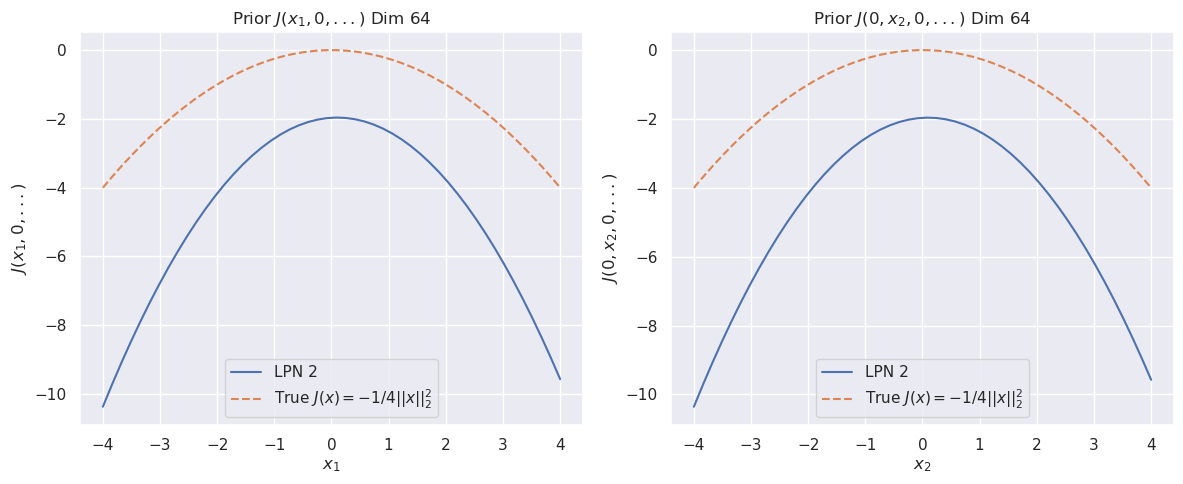

In [11]:
def evaluate_learned_J_G_network(x_points, model_G):
    """
    Evaluates the learned prior J(x) using the trained G(x) network.
    J(x) = G(x) - 0.5 * ||x||^2
    """
    # Convert to tensor
    x_tensor = torch.from_numpy(x_points).float().to(device)
    
    # Get G(x) from the second LPN model
    G_x = model_G.scalar(x_tensor)
    
    # Compute 0.5 * ||x||^2
    x_norm_sq_np = euclid_norm_sq(x_points)
    x_norm_sq_tensor = torch.from_numpy(x_norm_sq_np).float().to(device).reshape(-1, 1)

    # Apply the formula: J_est = G(x) - 0.5 * ||x||^2
    J_est = G_x - 0.5 * x_norm_sq_tensor
    
    # Convert back to numpy
    J_est_np = J_est.detach().cpu().numpy().flatten()
    
    return J_est_np

def plot_J_G_network(model_G, a, spacing, dim):
    """Plots the cross-sections of the estimated prior J(x) from the G network."""
    xi, x1_0_points, x2_0_points = compute_square_cross_sections(a, spacing, dim)
    
    # True Prior
    x1_0_J_true = prior_true_concave_quad(x1_0_points)
    if dim > 1:
        x2_0_J_true = prior_true_concave_quad(x2_0_points)
    else:
        x2_0_J_true = x1_0_J_true
        
    # Estimated Prior from G(x) Network
    x1_0_J_G_est = evaluate_learned_J_G_network(x1_0_points, model_G)
    if dim > 1:
        x2_0_J_G_est = evaluate_learned_J_G_network(x2_0_points, model_G)
    else:
        x2_0_J_G_est = x1_0_J_G_est
    
    print("\n--- Plotting Estimated Prior J(x) from LPN 2 ---")
    plt.figure(figsize=(12,5))
    
    plt.subplot(1, 2, 1)
    plt.plot(xi, x1_0_J_G_est, "-", label="LPN 2")
    plt.plot(xi, x1_0_J_true, "--", label="True $J(x)=-1/4||x||_2^2$")
    plt.grid(True)
    plt.title(f"Prior $J(x_1,0,...)$ Dim {dim}")
    plt.xlabel('$x_1$')
    plt.ylabel('$J(x_1,0,...)$')
    plt.legend()

    if dim > 1:
        plt.subplot(1, 2, 2)
        plt.plot(xi, x2_0_J_G_est, "-", label="LPN 2")
        plt.plot(xi, x2_0_J_true, "--", label="True $J(x)=-1/4||x||_2^2$")
        plt.grid(True)
        plt.title(f"Prior $J(0,x_2,0,...)$ Dim {dim}")
        plt.xlabel('$x_2$')
        plt.ylabel('$J(0,x_2,0,...)$')
        plt.legend()
    plt.tight_layout()
    #plt.savefig('G_network_prior_plot.png')
    
# --- Execute Plotting ---
plot_J_G_network(lpn_model_G, a_exp, spacing, dim_exp)